In [213]:
import os, sys
import torch as th
from sklearn.metrics import log_loss, accuracy_score
import openml
import optuna

In [2]:
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
from src.plotting import plot_roc, plot_losses
from src.modeling import (
    NumericEmbedding, train, data_split, decision_tree_encoding, decision_tree_encoding_multi,
    FeedForwardMLPResidual
)

In [5]:
SUITE_ID = 297 # Regression on numerical features

In [6]:
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

In [7]:
benchmark_suite

OpenML Benchmark Suite
ID..............: 297
Name............: Tabular benchmark numerical regression
Status..........: in_preparation
Main Entity Type: task
Study URL.......: https://www.openml.org/s/297
# of Data.......: 20
# of Tasks......: 20
Creator.........: https://www.openml.org/u/26324
Upload Time.....: 2022-07-10 10:45:09

In [8]:
# benchmark_suite.tasks

In [9]:
task_id = 361070 # eye movement

In [10]:
task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

In [11]:
df, y, categorical_indicator, features = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)
y = (y==y[0]).astype(int).values

In [12]:
df.head()

,lineNo,assgNo,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,firstSaccLen,lastSaccLen,prevFixPos,landingPos,leavingPos,totalFixDur,meanFixDur,regressLen,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg,titleNo,wordNo
0,9684.0,298.0,99.0,119.0,119.0,238.0,300.1666,288.0156,246.0732,56.6326,51.1786,119.0,119.0000,0.0,0.0,0.1541,0.4446,0.0176,4,3
1,2065.0,66.0,119.0,159.0,239.0,100.0,306.1066,117.2359,321.0140,47.3207,47.0425,239.0,119.5000,0.0,159.0,0.0119,0.3264,0.0239,8,1
2,1969.0,61.0,139.0,139.0,357.0,179.0,590.5294,805.0531,479.3078,112.3610,118.6529,536.0,178.6667,258.0,0.0,0.0874,0.0859,0.0431,4,8
3,10326.0,315.0,199.0,139.0,219.0,99.0,80.9475,306.5587,153.1698,79.8389,78.5875,198.0,99.0000,0.0,396.0,0.0173,0.1453,0.0264,4,2
4,6827.0,204.0,80.0,100.0,239.0,139.0,110.7576,161.4845,189.6207,96.7471,102.1225,139.0,139.0000,0.0,378.0,0.3229,0.4074,0.0288,2,1


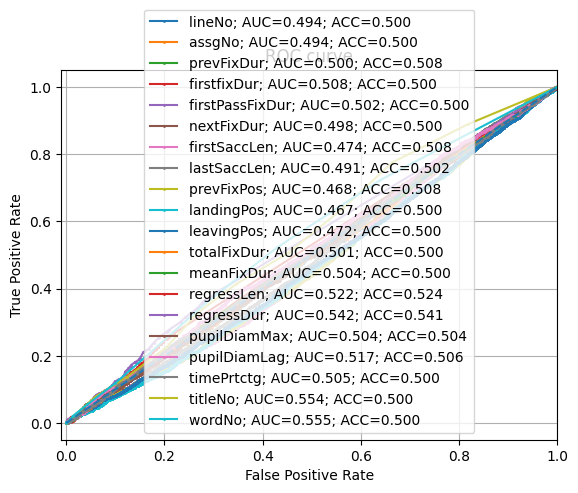

In [13]:
plot_roc(y, [df[c].values for c in features], features, x_max=1.0)

## Modeling
### Data splitting

In [14]:
Xs, ys = data_split(df.values, y, 0.7, 0.09)

In [15]:
{k: v.shape for k, v in Xs.items()}

{'train': torch.Size([5325, 20]),
 'valid': torch.Size([684, 20]),
 'test': torch.Size([1599, 20])}

In [16]:
{k: v.shape for k, v in ys.items()}

{'train': torch.Size([5325]),
 'valid': torch.Size([684]),
 'test': torch.Size([1599])}

### Random Forest

In [322]:
from sklearn.ensemble import RandomForestClassifier

In [323]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 30, 500)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    clf_rf.fit(Xs['train'], ys['train'])
    return accuracy_score(ys['valid'], clf_rf.predict(Xs['valid']))

In [224]:
study_rf = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="eye-movement-rf",
    direction='maximize',
)  # Create a new study.
study_rf.optimize(objective_rf, n_trials=30)  # Invoke optimization of the objective function.

[I 2023-01-23 12:22:17,283] A new study created in RDB with name: eye-movement-rf
[I 2023-01-23 12:22:18,046] Trial 0 finished with value: 0.5906432748538012 and parameters: {'n_estimators': 274, 'max_depth': 3}. Best is trial 0 with value: 0.5906432748538012.
[I 2023-01-23 12:22:18,826] Trial 1 finished with value: 0.6067251461988304 and parameters: {'n_estimators': 256, 'max_depth': 4}. Best is trial 1 with value: 0.6067251461988304.
[I 2023-01-23 12:22:20,117] Trial 2 finished with value: 0.6271929824561403 and parameters: {'n_estimators': 257, 'max_depth': 8}. Best is trial 2 with value: 0.6271929824561403.
[I 2023-01-23 12:22:22,282] Trial 3 finished with value: 0.618421052631579 and parameters: {'n_estimators': 390, 'max_depth': 9}. Best is trial 2 with value: 0.6271929824561403.
[I 2023-01-23 12:22:22,496] Trial 4 finished with value: 0.6169590643274854 and parameters: {'n_estimators': 30, 'max_depth': 12}. Best is trial 2 with value: 0.6271929824561403.
[I 2023-01-23 12:22:24,0

In [225]:
best_params_rf = study_rf.best_params
best_params_rf

{'max_depth': 10, 'n_estimators': 126}

In [226]:
clf_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'], 
    max_depth=best_params_rf['max_depth']
)
clf_rf.fit(Xs['train'], ys['train'])
y_hat_rf = clf_rf.predict_proba(Xs['test'])[:,1]

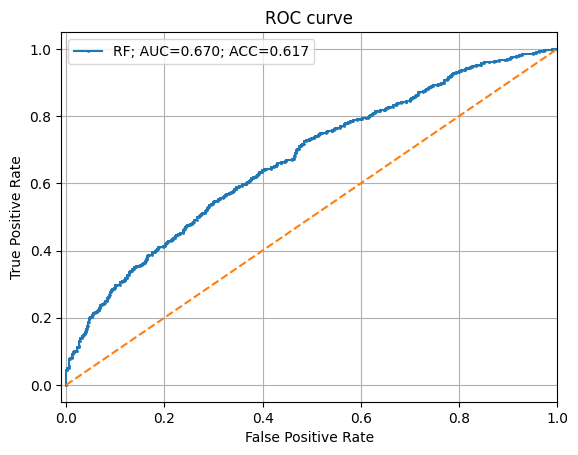

In [227]:
plot_roc(ys['test'],[y_hat_rf], ['RF'])

### XGBoost

In [228]:
from xgboost import XGBClassifier

In [229]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 30, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    bst = XGBClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate, 
        objective='binary:logistic',
        reg_alpha=2,
        early_stopping_rounds=40
    )
    bst.fit(
        Xs['train'], ys['train'], 
        eval_set=[(Xs['train'], ys['train']), (Xs['valid'], ys['valid'])]
    )
#     return log_loss(ys['valid'], bst.predict_proba(Xs['valid'])[:,1])
    return accuracy_score(ys['valid'], bst.predict(Xs['valid']))

In [230]:
study_xgb = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="eye-movement-xgb_v2",
    direction='maximize',
)  # Create a new study.
study_xgb.optimize(objective_xgb, n_trials=30)  # Invoke optimization of the objective function.

[I 2023-01-23 12:23:51,540] A new study created in RDB with name: eye-movement-xgb_v2


[0]	validation_0-logloss:0.68761	validation_1-logloss:0.69015
[1]	validation_0-logloss:0.68271	validation_1-logloss:0.68668
[2]	validation_0-logloss:0.67845	validation_1-logloss:0.68395
[3]	validation_0-logloss:0.67465	validation_1-logloss:0.68202
[4]	validation_0-logloss:0.67126	validation_1-logloss:0.67923
[5]	validation_0-logloss:0.66809	validation_1-logloss:0.67810
[6]	validation_0-logloss:0.66524	validation_1-logloss:0.67663
[7]	validation_0-logloss:0.66275	validation_1-logloss:0.67556
[8]	validation_0-logloss:0.66001	validation_1-logloss:0.67492
[9]	validation_0-logloss:0.65756	validation_1-logloss:0.67406
[10]	validation_0-logloss:0.65490	validation_1-logloss:0.67250
[11]	validation_0-logloss:0.65230	validation_1-logloss:0.67041
[12]	validation_0-logloss:0.65014	validation_1-logloss:0.66971
[13]	validation_0-logloss:0.64813	validation_1-logloss:0.66876
[14]	validation_0-logloss:0.64613	validation_1-logloss:0.66796
[15]	validation_0-logloss:0.64357	validation_1-logloss:0.66586
[1

[130]	validation_0-logloss:0.52704	validation_1-logloss:0.64237
[131]	validation_0-logloss:0.52634	validation_1-logloss:0.64234
[132]	validation_0-logloss:0.52572	validation_1-logloss:0.64206
[133]	validation_0-logloss:0.52509	validation_1-logloss:0.64191
[134]	validation_0-logloss:0.52448	validation_1-logloss:0.64155
[135]	validation_0-logloss:0.52381	validation_1-logloss:0.64145
[136]	validation_0-logloss:0.52315	validation_1-logloss:0.64171
[137]	validation_0-logloss:0.52249	validation_1-logloss:0.64204
[138]	validation_0-logloss:0.52177	validation_1-logloss:0.64195
[139]	validation_0-logloss:0.52106	validation_1-logloss:0.64224
[140]	validation_0-logloss:0.52041	validation_1-logloss:0.64241
[141]	validation_0-logloss:0.51998	validation_1-logloss:0.64240
[142]	validation_0-logloss:0.51960	validation_1-logloss:0.64235
[143]	validation_0-logloss:0.51869	validation_1-logloss:0.64283
[144]	validation_0-logloss:0.51809	validation_1-logloss:0.64262
[145]	validation_0-logloss:0.51729	valid

[I 2023-01-23 12:23:53,891] Trial 0 finished with value: 0.6345029239766082 and parameters: {'n_estimators': 714, 'max_depth': 4, 'learning_rate': 0.08908528670568112}. Best is trial 0 with value: 0.6345029239766082.


[0]	validation_0-logloss:0.69216	validation_1-logloss:0.69266
[1]	validation_0-logloss:0.69121	validation_1-logloss:0.69218
[2]	validation_0-logloss:0.69021	validation_1-logloss:0.69156
[3]	validation_0-logloss:0.68925	validation_1-logloss:0.69089
[4]	validation_0-logloss:0.68830	validation_1-logloss:0.69025
[5]	validation_0-logloss:0.68743	validation_1-logloss:0.68976
[6]	validation_0-logloss:0.68653	validation_1-logloss:0.68913
[7]	validation_0-logloss:0.68565	validation_1-logloss:0.68854
[8]	validation_0-logloss:0.68475	validation_1-logloss:0.68794
[9]	validation_0-logloss:0.68391	validation_1-logloss:0.68743
[10]	validation_0-logloss:0.68311	validation_1-logloss:0.68703
[11]	validation_0-logloss:0.68229	validation_1-logloss:0.68655
[12]	validation_0-logloss:0.68147	validation_1-logloss:0.68610
[13]	validation_0-logloss:0.68067	validation_1-logloss:0.68588
[14]	validation_0-logloss:0.67987	validation_1-logloss:0.68538
[15]	validation_0-logloss:0.67910	validation_1-logloss:0.68513
[1

[130]	validation_0-logloss:0.62153	validation_1-logloss:0.66020
[131]	validation_0-logloss:0.62104	validation_1-logloss:0.66005
[132]	validation_0-logloss:0.62071	validation_1-logloss:0.65988
[133]	validation_0-logloss:0.62029	validation_1-logloss:0.65990
[134]	validation_0-logloss:0.61995	validation_1-logloss:0.65985
[135]	validation_0-logloss:0.61957	validation_1-logloss:0.65981
[136]	validation_0-logloss:0.61922	validation_1-logloss:0.65963
[137]	validation_0-logloss:0.61884	validation_1-logloss:0.65960
[138]	validation_0-logloss:0.61845	validation_1-logloss:0.65962
[139]	validation_0-logloss:0.61815	validation_1-logloss:0.65946
[140]	validation_0-logloss:0.61778	validation_1-logloss:0.65944
[141]	validation_0-logloss:0.61748	validation_1-logloss:0.65933
[142]	validation_0-logloss:0.61714	validation_1-logloss:0.65935
[143]	validation_0-logloss:0.61681	validation_1-logloss:0.65940
[144]	validation_0-logloss:0.61637	validation_1-logloss:0.65919
[145]	validation_0-logloss:0.61604	valid

[259]	validation_0-logloss:0.58225	validation_1-logloss:0.65022
[260]	validation_0-logloss:0.58210	validation_1-logloss:0.65014
[261]	validation_0-logloss:0.58199	validation_1-logloss:0.65012
[262]	validation_0-logloss:0.58180	validation_1-logloss:0.65012
[263]	validation_0-logloss:0.58157	validation_1-logloss:0.65011
[264]	validation_0-logloss:0.58131	validation_1-logloss:0.65009
[265]	validation_0-logloss:0.58101	validation_1-logloss:0.65000
[266]	validation_0-logloss:0.58092	validation_1-logloss:0.65000
[267]	validation_0-logloss:0.58076	validation_1-logloss:0.64995
[268]	validation_0-logloss:0.58051	validation_1-logloss:0.64980
[269]	validation_0-logloss:0.58041	validation_1-logloss:0.64980
[270]	validation_0-logloss:0.58026	validation_1-logloss:0.64972
[271]	validation_0-logloss:0.58001	validation_1-logloss:0.64960
[272]	validation_0-logloss:0.57991	validation_1-logloss:0.64959
[273]	validation_0-logloss:0.57976	validation_1-logloss:0.64955
[274]	validation_0-logloss:0.57954	valid

[388]	validation_0-logloss:0.55866	validation_1-logloss:0.64449
[389]	validation_0-logloss:0.55843	validation_1-logloss:0.64448
[390]	validation_0-logloss:0.55821	validation_1-logloss:0.64447
[391]	validation_0-logloss:0.55797	validation_1-logloss:0.64441
[392]	validation_0-logloss:0.55784	validation_1-logloss:0.64443
[393]	validation_0-logloss:0.55764	validation_1-logloss:0.64429
[394]	validation_0-logloss:0.55752	validation_1-logloss:0.64432
[395]	validation_0-logloss:0.55730	validation_1-logloss:0.64432
[396]	validation_0-logloss:0.55711	validation_1-logloss:0.64428
[397]	validation_0-logloss:0.55704	validation_1-logloss:0.64429
[398]	validation_0-logloss:0.55681	validation_1-logloss:0.64427
[399]	validation_0-logloss:0.55661	validation_1-logloss:0.64423
[400]	validation_0-logloss:0.55650	validation_1-logloss:0.64417
[401]	validation_0-logloss:0.55631	validation_1-logloss:0.64410
[402]	validation_0-logloss:0.55624	validation_1-logloss:0.64409
[403]	validation_0-logloss:0.55611	valid

[517]	validation_0-logloss:0.53484	validation_1-logloss:0.64206
[518]	validation_0-logloss:0.53461	validation_1-logloss:0.64205
[519]	validation_0-logloss:0.53445	validation_1-logloss:0.64210
[520]	validation_0-logloss:0.53437	validation_1-logloss:0.64207
[521]	validation_0-logloss:0.53428	validation_1-logloss:0.64209
[522]	validation_0-logloss:0.53400	validation_1-logloss:0.64203
[523]	validation_0-logloss:0.53375	validation_1-logloss:0.64207
[524]	validation_0-logloss:0.53357	validation_1-logloss:0.64216
[525]	validation_0-logloss:0.53337	validation_1-logloss:0.64209
[526]	validation_0-logloss:0.53319	validation_1-logloss:0.64207
[527]	validation_0-logloss:0.53295	validation_1-logloss:0.64192
[528]	validation_0-logloss:0.53284	validation_1-logloss:0.64198
[529]	validation_0-logloss:0.53260	validation_1-logloss:0.64192
[530]	validation_0-logloss:0.53240	validation_1-logloss:0.64185
[531]	validation_0-logloss:0.53224	validation_1-logloss:0.64185
[532]	validation_0-logloss:0.53199	valid

[I 2023-01-23 12:24:00,810] Trial 1 finished with value: 0.6330409356725146 and parameters: {'n_estimators': 535, 'max_depth': 5, 'learning_rate': 0.011671562410679603}. Best is trial 0 with value: 0.6345029239766082.


[0]	validation_0-logloss:0.68699	validation_1-logloss:0.69023
[1]	validation_0-logloss:0.68139	validation_1-logloss:0.68699
[2]	validation_0-logloss:0.67628	validation_1-logloss:0.68375
[3]	validation_0-logloss:0.67156	validation_1-logloss:0.68204
[4]	validation_0-logloss:0.66727	validation_1-logloss:0.68070
[5]	validation_0-logloss:0.66321	validation_1-logloss:0.67930
[6]	validation_0-logloss:0.65939	validation_1-logloss:0.67698
[7]	validation_0-logloss:0.65576	validation_1-logloss:0.67606
[8]	validation_0-logloss:0.65249	validation_1-logloss:0.67537
[9]	validation_0-logloss:0.64910	validation_1-logloss:0.67403
[10]	validation_0-logloss:0.64654	validation_1-logloss:0.67267
[11]	validation_0-logloss:0.64359	validation_1-logloss:0.67147
[12]	validation_0-logloss:0.64057	validation_1-logloss:0.67052
[13]	validation_0-logloss:0.63772	validation_1-logloss:0.66968
[14]	validation_0-logloss:0.63457	validation_1-logloss:0.66660
[15]	validation_0-logloss:0.63192	validation_1-logloss:0.66524
[1

[130]	validation_0-logloss:0.47637	validation_1-logloss:0.64004
[131]	validation_0-logloss:0.47527	validation_1-logloss:0.64000
[132]	validation_0-logloss:0.47429	validation_1-logloss:0.64029
[133]	validation_0-logloss:0.47306	validation_1-logloss:0.63935
[134]	validation_0-logloss:0.47215	validation_1-logloss:0.63913
[135]	validation_0-logloss:0.47112	validation_1-logloss:0.63897
[136]	validation_0-logloss:0.47009	validation_1-logloss:0.63888
[137]	validation_0-logloss:0.46943	validation_1-logloss:0.63885
[138]	validation_0-logloss:0.46839	validation_1-logloss:0.63861
[139]	validation_0-logloss:0.46735	validation_1-logloss:0.63887
[140]	validation_0-logloss:0.46697	validation_1-logloss:0.63895
[141]	validation_0-logloss:0.46591	validation_1-logloss:0.63897
[142]	validation_0-logloss:0.46513	validation_1-logloss:0.63867
[143]	validation_0-logloss:0.46419	validation_1-logloss:0.63916
[144]	validation_0-logloss:0.46322	validation_1-logloss:0.63946
[145]	validation_0-logloss:0.46241	valid

[I 2023-01-23 12:24:04,945] Trial 2 finished with value: 0.6257309941520468 and parameters: {'n_estimators': 802, 'max_depth': 5, 'learning_rate': 0.07506996724136639}. Best is trial 0 with value: 0.6345029239766082.


[0]	validation_0-logloss:0.67990	validation_1-logloss:0.68953
[1]	validation_0-logloss:0.66703	validation_1-logloss:0.68385
[2]	validation_0-logloss:0.65523	validation_1-logloss:0.68027
[3]	validation_0-logloss:0.64366	validation_1-logloss:0.67566
[4]	validation_0-logloss:0.63250	validation_1-logloss:0.67275
[5]	validation_0-logloss:0.62180	validation_1-logloss:0.67052
[6]	validation_0-logloss:0.61179	validation_1-logloss:0.66714
[7]	validation_0-logloss:0.60203	validation_1-logloss:0.66523
[8]	validation_0-logloss:0.59428	validation_1-logloss:0.66346
[9]	validation_0-logloss:0.58610	validation_1-logloss:0.66345
[10]	validation_0-logloss:0.57820	validation_1-logloss:0.66136
[11]	validation_0-logloss:0.57002	validation_1-logloss:0.65925
[12]	validation_0-logloss:0.56338	validation_1-logloss:0.65768
[13]	validation_0-logloss:0.55756	validation_1-logloss:0.65684
[14]	validation_0-logloss:0.55014	validation_1-logloss:0.65475
[15]	validation_0-logloss:0.54345	validation_1-logloss:0.65438
[1

[I 2023-01-23 12:24:07,730] Trial 3 finished with value: 0.6388888888888888 and parameters: {'n_estimators': 396, 'max_depth': 9, 'learning_rate': 0.06916500333969766}. Best is trial 3 with value: 0.6388888888888888.


[0]	validation_0-logloss:0.69175	validation_1-logloss:0.69237
[1]	validation_0-logloss:0.69038	validation_1-logloss:0.69147
[2]	validation_0-logloss:0.68909	validation_1-logloss:0.69065
[3]	validation_0-logloss:0.68781	validation_1-logloss:0.68968
[4]	validation_0-logloss:0.68657	validation_1-logloss:0.68885
[5]	validation_0-logloss:0.68539	validation_1-logloss:0.68799
[6]	validation_0-logloss:0.68425	validation_1-logloss:0.68738
[7]	validation_0-logloss:0.68313	validation_1-logloss:0.68638
[8]	validation_0-logloss:0.68207	validation_1-logloss:0.68591
[9]	validation_0-logloss:0.68105	validation_1-logloss:0.68524
[10]	validation_0-logloss:0.68001	validation_1-logloss:0.68481
[11]	validation_0-logloss:0.67901	validation_1-logloss:0.68396
[12]	validation_0-logloss:0.67806	validation_1-logloss:0.68349
[13]	validation_0-logloss:0.67718	validation_1-logloss:0.68293
[14]	validation_0-logloss:0.67625	validation_1-logloss:0.68250
[15]	validation_0-logloss:0.67535	validation_1-logloss:0.68184
[1

[I 2023-01-23 12:24:08,474] Trial 4 finished with value: 0.6125730994152047 and parameters: {'n_estimators': 67, 'max_depth': 4, 'learning_rate': 0.02170434105951404}. Best is trial 3 with value: 0.6388888888888888.


[0]	validation_0-logloss:0.68337	validation_1-logloss:0.69042
[1]	validation_0-logloss:0.67355	validation_1-logloss:0.68653
[2]	validation_0-logloss:0.66505	validation_1-logloss:0.68327
[3]	validation_0-logloss:0.65627	validation_1-logloss:0.67950
[4]	validation_0-logloss:0.64729	validation_1-logloss:0.67605
[5]	validation_0-logloss:0.63900	validation_1-logloss:0.67393
[6]	validation_0-logloss:0.63133	validation_1-logloss:0.67196
[7]	validation_0-logloss:0.62379	validation_1-logloss:0.66977
[8]	validation_0-logloss:0.61618	validation_1-logloss:0.66809
[9]	validation_0-logloss:0.60901	validation_1-logloss:0.66632
[10]	validation_0-logloss:0.60199	validation_1-logloss:0.66446
[11]	validation_0-logloss:0.59477	validation_1-logloss:0.66217
[12]	validation_0-logloss:0.58871	validation_1-logloss:0.66141
[13]	validation_0-logloss:0.58250	validation_1-logloss:0.66074
[14]	validation_0-logloss:0.57710	validation_1-logloss:0.66014
[15]	validation_0-logloss:0.57114	validation_1-logloss:0.65901
[1

[130]	validation_0-logloss:0.28323	validation_1-logloss:0.62887
[131]	validation_0-logloss:0.28155	validation_1-logloss:0.62932
[132]	validation_0-logloss:0.28011	validation_1-logloss:0.62985
[133]	validation_0-logloss:0.27844	validation_1-logloss:0.62981
[134]	validation_0-logloss:0.27694	validation_1-logloss:0.63054
[135]	validation_0-logloss:0.27658	validation_1-logloss:0.63066
[136]	validation_0-logloss:0.27534	validation_1-logloss:0.63022
[137]	validation_0-logloss:0.27401	validation_1-logloss:0.63014
[138]	validation_0-logloss:0.27277	validation_1-logloss:0.63014
[139]	validation_0-logloss:0.27156	validation_1-logloss:0.62940
[140]	validation_0-logloss:0.27031	validation_1-logloss:0.62952
[141]	validation_0-logloss:0.26913	validation_1-logloss:0.62973
[142]	validation_0-logloss:0.26796	validation_1-logloss:0.63023
[143]	validation_0-logloss:0.26680	validation_1-logloss:0.63056
[144]	validation_0-logloss:0.26564	validation_1-logloss:0.63010
[145]	validation_0-logloss:0.26455	valid

[I 2023-01-23 12:24:12,423] Trial 5 finished with value: 0.6359649122807017 and parameters: {'n_estimators': 904, 'max_depth': 9, 'learning_rate': 0.05067829059369533}. Best is trial 3 with value: 0.6388888888888888.


[0]	validation_0-logloss:0.68677	validation_1-logloss:0.69132
[1]	validation_0-logloss:0.68039	validation_1-logloss:0.68980
[2]	validation_0-logloss:0.67415	validation_1-logloss:0.68786
[3]	validation_0-logloss:0.66805	validation_1-logloss:0.68644
[4]	validation_0-logloss:0.66182	validation_1-logloss:0.68500
[5]	validation_0-logloss:0.65607	validation_1-logloss:0.68402
[6]	validation_0-logloss:0.65024	validation_1-logloss:0.68283
[7]	validation_0-logloss:0.64450	validation_1-logloss:0.68154
[8]	validation_0-logloss:0.63920	validation_1-logloss:0.68001
[9]	validation_0-logloss:0.63408	validation_1-logloss:0.67872
[10]	validation_0-logloss:0.62889	validation_1-logloss:0.67763
[11]	validation_0-logloss:0.62386	validation_1-logloss:0.67665
[12]	validation_0-logloss:0.61913	validation_1-logloss:0.67553
[13]	validation_0-logloss:0.61417	validation_1-logloss:0.67462
[14]	validation_0-logloss:0.60889	validation_1-logloss:0.67338
[15]	validation_0-logloss:0.60393	validation_1-logloss:0.67210
[1

[I 2023-01-23 12:24:16,277] Trial 6 finished with value: 0.6301169590643275 and parameters: {'n_estimators': 112, 'max_depth': 12, 'learning_rate': 0.02471749999443275}. Best is trial 3 with value: 0.6388888888888888.


[0]	validation_0-logloss:0.69042	validation_1-logloss:0.69105
[1]	validation_0-logloss:0.68795	validation_1-logloss:0.68915
[2]	validation_0-logloss:0.68572	validation_1-logloss:0.68726
[3]	validation_0-logloss:0.68367	validation_1-logloss:0.68589
[4]	validation_0-logloss:0.68179	validation_1-logloss:0.68442
[5]	validation_0-logloss:0.68004	validation_1-logloss:0.68314
[6]	validation_0-logloss:0.67842	validation_1-logloss:0.68237
[7]	validation_0-logloss:0.67692	validation_1-logloss:0.68116
[8]	validation_0-logloss:0.67554	validation_1-logloss:0.68067
[9]	validation_0-logloss:0.67424	validation_1-logloss:0.68002
[10]	validation_0-logloss:0.67306	validation_1-logloss:0.67943
[11]	validation_0-logloss:0.67180	validation_1-logloss:0.67842
[12]	validation_0-logloss:0.67080	validation_1-logloss:0.67775
[13]	validation_0-logloss:0.66964	validation_1-logloss:0.67698
[14]	validation_0-logloss:0.66867	validation_1-logloss:0.67655
[15]	validation_0-logloss:0.66763	validation_1-logloss:0.67591
[1

[130]	validation_0-logloss:0.61359	validation_1-logloss:0.65465
[131]	validation_0-logloss:0.61327	validation_1-logloss:0.65451
[132]	validation_0-logloss:0.61283	validation_1-logloss:0.65453
[133]	validation_0-logloss:0.61252	validation_1-logloss:0.65441
[134]	validation_0-logloss:0.61232	validation_1-logloss:0.65418
[135]	validation_0-logloss:0.61206	validation_1-logloss:0.65419
[136]	validation_0-logloss:0.61182	validation_1-logloss:0.65435
[137]	validation_0-logloss:0.61149	validation_1-logloss:0.65440
[138]	validation_0-logloss:0.61095	validation_1-logloss:0.65424
[139]	validation_0-logloss:0.61060	validation_1-logloss:0.65372
[140]	validation_0-logloss:0.61010	validation_1-logloss:0.65353
[141]	validation_0-logloss:0.60993	validation_1-logloss:0.65350
[142]	validation_0-logloss:0.60970	validation_1-logloss:0.65358
[143]	validation_0-logloss:0.60933	validation_1-logloss:0.65336
[144]	validation_0-logloss:0.60901	validation_1-logloss:0.65333
[145]	validation_0-logloss:0.60858	valid

[258]	validation_0-logloss:0.57738	validation_1-logloss:0.64627
[259]	validation_0-logloss:0.57703	validation_1-logloss:0.64620
[260]	validation_0-logloss:0.57683	validation_1-logloss:0.64630
[261]	validation_0-logloss:0.57653	validation_1-logloss:0.64606
[262]	validation_0-logloss:0.57638	validation_1-logloss:0.64615
[263]	validation_0-logloss:0.57611	validation_1-logloss:0.64619
[264]	validation_0-logloss:0.57590	validation_1-logloss:0.64642
[265]	validation_0-logloss:0.57564	validation_1-logloss:0.64659
[266]	validation_0-logloss:0.57544	validation_1-logloss:0.64664
[267]	validation_0-logloss:0.57511	validation_1-logloss:0.64681
[268]	validation_0-logloss:0.57486	validation_1-logloss:0.64674
[269]	validation_0-logloss:0.57457	validation_1-logloss:0.64691
[270]	validation_0-logloss:0.57444	validation_1-logloss:0.64700
[271]	validation_0-logloss:0.57412	validation_1-logloss:0.64730
[272]	validation_0-logloss:0.57382	validation_1-logloss:0.64723
[273]	validation_0-logloss:0.57373	valid

[I 2023-01-23 12:24:18,538] Trial 7 finished with value: 0.6301169590643275 and parameters: {'n_estimators': 296, 'max_depth': 3, 'learning_rate': 0.05495062018928777}. Best is trial 3 with value: 0.6388888888888888.


[0]	validation_0-logloss:0.66907	validation_1-logloss:0.68675
[1]	validation_0-logloss:0.64512	validation_1-logloss:0.68095
[2]	validation_0-logloss:0.62472	validation_1-logloss:0.67680
[3]	validation_0-logloss:0.60494	validation_1-logloss:0.67332
[4]	validation_0-logloss:0.58555	validation_1-logloss:0.66831
[5]	validation_0-logloss:0.56842	validation_1-logloss:0.66497
[6]	validation_0-logloss:0.55205	validation_1-logloss:0.66290
[7]	validation_0-logloss:0.53750	validation_1-logloss:0.66032
[8]	validation_0-logloss:0.52364	validation_1-logloss:0.65627
[9]	validation_0-logloss:0.50989	validation_1-logloss:0.65469
[10]	validation_0-logloss:0.49770	validation_1-logloss:0.65429
[11]	validation_0-logloss:0.48625	validation_1-logloss:0.65415
[12]	validation_0-logloss:0.47361	validation_1-logloss:0.65322
[13]	validation_0-logloss:0.46340	validation_1-logloss:0.65452
[14]	validation_0-logloss:0.45268	validation_1-logloss:0.65077
[15]	validation_0-logloss:0.44372	validation_1-logloss:0.64888
[1

[I 2023-01-23 12:24:22,182] Trial 8 finished with value: 0.6374269005847953 and parameters: {'n_estimators': 862, 'max_depth': 12, 'learning_rate': 0.09587948927469897}. Best is trial 3 with value: 0.6388888888888888.


[0]	validation_0-logloss:0.68490	validation_1-logloss:0.69081
[1]	validation_0-logloss:0.67646	validation_1-logloss:0.68853
[2]	validation_0-logloss:0.66849	validation_1-logloss:0.68631
[3]	validation_0-logloss:0.66103	validation_1-logloss:0.68459
[4]	validation_0-logloss:0.65318	validation_1-logloss:0.68273
[5]	validation_0-logloss:0.64540	validation_1-logloss:0.68051
[6]	validation_0-logloss:0.63857	validation_1-logloss:0.67835
[7]	validation_0-logloss:0.63174	validation_1-logloss:0.67681
[8]	validation_0-logloss:0.62520	validation_1-logloss:0.67508
[9]	validation_0-logloss:0.61865	validation_1-logloss:0.67385
[10]	validation_0-logloss:0.61175	validation_1-logloss:0.67226
[11]	validation_0-logloss:0.60562	validation_1-logloss:0.67060
[12]	validation_0-logloss:0.59977	validation_1-logloss:0.66881
[13]	validation_0-logloss:0.59347	validation_1-logloss:0.66723
[14]	validation_0-logloss:0.58750	validation_1-logloss:0.66651
[15]	validation_0-logloss:0.58217	validation_1-logloss:0.66605
[1

[130]	validation_0-logloss:0.27223	validation_1-logloss:0.63821
[131]	validation_0-logloss:0.27120	validation_1-logloss:0.63799
[132]	validation_0-logloss:0.26984	validation_1-logloss:0.63749
[133]	validation_0-logloss:0.26875	validation_1-logloss:0.63785
[134]	validation_0-logloss:0.26781	validation_1-logloss:0.63781
[135]	validation_0-logloss:0.26644	validation_1-logloss:0.63782
[136]	validation_0-logloss:0.26513	validation_1-logloss:0.63817
[137]	validation_0-logloss:0.26383	validation_1-logloss:0.63824
[138]	validation_0-logloss:0.26291	validation_1-logloss:0.63810
[139]	validation_0-logloss:0.26163	validation_1-logloss:0.63823
[140]	validation_0-logloss:0.26052	validation_1-logloss:0.63809
[141]	validation_0-logloss:0.25904	validation_1-logloss:0.63770
[142]	validation_0-logloss:0.25783	validation_1-logloss:0.63736
[143]	validation_0-logloss:0.25684	validation_1-logloss:0.63743
[144]	validation_0-logloss:0.25555	validation_1-logloss:0.63763
[145]	validation_0-logloss:0.25421	valid

[I 2023-01-23 12:24:28,760] Trial 9 finished with value: 0.6549707602339181 and parameters: {'n_estimators': 248, 'max_depth': 12, 'learning_rate': 0.032031586079990716}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68450	validation_1-logloss:0.69065
[1]	validation_0-logloss:0.67553	validation_1-logloss:0.68739
[2]	validation_0-logloss:0.66770	validation_1-logloss:0.68453
[3]	validation_0-logloss:0.66002	validation_1-logloss:0.68184
[4]	validation_0-logloss:0.65214	validation_1-logloss:0.67942
[5]	validation_0-logloss:0.64500	validation_1-logloss:0.67730
[6]	validation_0-logloss:0.63831	validation_1-logloss:0.67567
[7]	validation_0-logloss:0.63139	validation_1-logloss:0.67478
[8]	validation_0-logloss:0.62408	validation_1-logloss:0.67257
[9]	validation_0-logloss:0.61704	validation_1-logloss:0.67042
[10]	validation_0-logloss:0.61035	validation_1-logloss:0.66800
[11]	validation_0-logloss:0.60398	validation_1-logloss:0.66621
[12]	validation_0-logloss:0.59758	validation_1-logloss:0.66449
[13]	validation_0-logloss:0.59157	validation_1-logloss:0.66397
[14]	validation_0-logloss:0.58513	validation_1-logloss:0.66212
[15]	validation_0-logloss:0.57961	validation_1-logloss:0.66089
[1

[130]	validation_0-logloss:0.28583	validation_1-logloss:0.63287
[131]	validation_0-logloss:0.28441	validation_1-logloss:0.63295
[132]	validation_0-logloss:0.28298	validation_1-logloss:0.63228
[133]	validation_0-logloss:0.28171	validation_1-logloss:0.63224
[134]	validation_0-logloss:0.28049	validation_1-logloss:0.63255
[135]	validation_0-logloss:0.27910	validation_1-logloss:0.63159
[136]	validation_0-logloss:0.27765	validation_1-logloss:0.63186
[137]	validation_0-logloss:0.27634	validation_1-logloss:0.63209
[138]	validation_0-logloss:0.27509	validation_1-logloss:0.63210
[139]	validation_0-logloss:0.27393	validation_1-logloss:0.63194
[140]	validation_0-logloss:0.27277	validation_1-logloss:0.63153
[141]	validation_0-logloss:0.27127	validation_1-logloss:0.63159
[142]	validation_0-logloss:0.27085	validation_1-logloss:0.63165
[143]	validation_0-logloss:0.26972	validation_1-logloss:0.63189
[144]	validation_0-logloss:0.26851	validation_1-logloss:0.63209
[145]	validation_0-logloss:0.26697	valid

[I 2023-01-23 12:24:33,779] Trial 10 finished with value: 0.6388888888888888 and parameters: {'n_estimators': 260, 'max_depth': 10, 'learning_rate': 0.03933825221042953}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68213	validation_1-logloss:0.68935
[1]	validation_0-logloss:0.67148	validation_1-logloss:0.68371
[2]	validation_0-logloss:0.66091	validation_1-logloss:0.68034
[3]	validation_0-logloss:0.65157	validation_1-logloss:0.67719
[4]	validation_0-logloss:0.64274	validation_1-logloss:0.67526
[5]	validation_0-logloss:0.63402	validation_1-logloss:0.67325
[6]	validation_0-logloss:0.62590	validation_1-logloss:0.67198
[7]	validation_0-logloss:0.61828	validation_1-logloss:0.67145
[8]	validation_0-logloss:0.61114	validation_1-logloss:0.67034
[9]	validation_0-logloss:0.60481	validation_1-logloss:0.66940
[10]	validation_0-logloss:0.59823	validation_1-logloss:0.66813
[11]	validation_0-logloss:0.59143	validation_1-logloss:0.66661
[12]	validation_0-logloss:0.58610	validation_1-logloss:0.66545
[13]	validation_0-logloss:0.57974	validation_1-logloss:0.66389
[14]	validation_0-logloss:0.57487	validation_1-logloss:0.66296
[15]	validation_0-logloss:0.56977	validation_1-logloss:0.66184
[1

[I 2023-01-23 12:24:35,677] Trial 11 finished with value: 0.6388888888888888 and parameters: {'n_estimators': 434, 'max_depth': 8, 'learning_rate': 0.0691430956431943}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68421	validation_1-logloss:0.69057
[1]	validation_0-logloss:0.67494	validation_1-logloss:0.68721
[2]	validation_0-logloss:0.66687	validation_1-logloss:0.68427
[3]	validation_0-logloss:0.65900	validation_1-logloss:0.68155
[4]	validation_0-logloss:0.65086	validation_1-logloss:0.67904
[5]	validation_0-logloss:0.64359	validation_1-logloss:0.67724
[6]	validation_0-logloss:0.63675	validation_1-logloss:0.67544
[7]	validation_0-logloss:0.62946	validation_1-logloss:0.67418
[8]	validation_0-logloss:0.62233	validation_1-logloss:0.67194
[9]	validation_0-logloss:0.61517	validation_1-logloss:0.66956
[10]	validation_0-logloss:0.60860	validation_1-logloss:0.66743
[11]	validation_0-logloss:0.60194	validation_1-logloss:0.66602
[12]	validation_0-logloss:0.59547	validation_1-logloss:0.66554
[13]	validation_0-logloss:0.58919	validation_1-logloss:0.66440
[14]	validation_0-logloss:0.58293	validation_1-logloss:0.66239
[15]	validation_0-logloss:0.57680	validation_1-logloss:0.66216
[1

[130]	validation_0-logloss:0.28024	validation_1-logloss:0.63019
[131]	validation_0-logloss:0.27899	validation_1-logloss:0.63052
[132]	validation_0-logloss:0.27772	validation_1-logloss:0.63076
[133]	validation_0-logloss:0.27655	validation_1-logloss:0.63063
[134]	validation_0-logloss:0.27511	validation_1-logloss:0.63117
[135]	validation_0-logloss:0.27410	validation_1-logloss:0.63137
[136]	validation_0-logloss:0.27293	validation_1-logloss:0.63131
[137]	validation_0-logloss:0.27180	validation_1-logloss:0.63106
[138]	validation_0-logloss:0.27053	validation_1-logloss:0.63112
[139]	validation_0-logloss:0.26963	validation_1-logloss:0.63142
[140]	validation_0-logloss:0.26853	validation_1-logloss:0.63135
[141]	validation_0-logloss:0.26810	validation_1-logloss:0.63117
[142]	validation_0-logloss:0.26696	validation_1-logloss:0.63151
[143]	validation_0-logloss:0.26569	validation_1-logloss:0.63178
[144]	validation_0-logloss:0.26468	validation_1-logloss:0.63180
[145]	validation_0-logloss:0.26357	valid

[I 2023-01-23 12:24:39,983] Trial 12 finished with value: 0.6491228070175439 and parameters: {'n_estimators': 499, 'max_depth': 10, 'learning_rate': 0.040700443934611565}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68432	validation_1-logloss:0.69053
[1]	validation_0-logloss:0.67523	validation_1-logloss:0.68772
[2]	validation_0-logloss:0.66681	validation_1-logloss:0.68568
[3]	validation_0-logloss:0.65879	validation_1-logloss:0.68343
[4]	validation_0-logloss:0.65065	validation_1-logloss:0.68145
[5]	validation_0-logloss:0.64279	validation_1-logloss:0.67914
[6]	validation_0-logloss:0.63550	validation_1-logloss:0.67740
[7]	validation_0-logloss:0.62794	validation_1-logloss:0.67492
[8]	validation_0-logloss:0.62062	validation_1-logloss:0.67323
[9]	validation_0-logloss:0.61329	validation_1-logloss:0.67192
[10]	validation_0-logloss:0.60629	validation_1-logloss:0.67011
[11]	validation_0-logloss:0.59961	validation_1-logloss:0.66829
[12]	validation_0-logloss:0.59404	validation_1-logloss:0.66748
[13]	validation_0-logloss:0.58752	validation_1-logloss:0.66618
[14]	validation_0-logloss:0.58133	validation_1-logloss:0.66516
[15]	validation_0-logloss:0.57539	validation_1-logloss:0.66440
[1

[130]	validation_0-logloss:0.26601	validation_1-logloss:0.62889
[131]	validation_0-logloss:0.26476	validation_1-logloss:0.62825
[132]	validation_0-logloss:0.26352	validation_1-logloss:0.62840
[133]	validation_0-logloss:0.26226	validation_1-logloss:0.62792
[134]	validation_0-logloss:0.26098	validation_1-logloss:0.62753
[135]	validation_0-logloss:0.25981	validation_1-logloss:0.62712
[136]	validation_0-logloss:0.25870	validation_1-logloss:0.62718
[137]	validation_0-logloss:0.25778	validation_1-logloss:0.62717
[138]	validation_0-logloss:0.25652	validation_1-logloss:0.62721
[139]	validation_0-logloss:0.25571	validation_1-logloss:0.62718
[140]	validation_0-logloss:0.25436	validation_1-logloss:0.62736
[141]	validation_0-logloss:0.25314	validation_1-logloss:0.62671
[142]	validation_0-logloss:0.25182	validation_1-logloss:0.62654
[143]	validation_0-logloss:0.25063	validation_1-logloss:0.62612
[144]	validation_0-logloss:0.24926	validation_1-logloss:0.62605
[145]	validation_0-logloss:0.24837	valid

[I 2023-01-23 12:24:45,206] Trial 13 finished with value: 0.6432748538011696 and parameters: {'n_estimators': 562, 'max_depth': 11, 'learning_rate': 0.036635583589208584}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68448	validation_1-logloss:0.69064
[1]	validation_0-logloss:0.67548	validation_1-logloss:0.68738
[2]	validation_0-logloss:0.66764	validation_1-logloss:0.68451
[3]	validation_0-logloss:0.65995	validation_1-logloss:0.68182
[4]	validation_0-logloss:0.65205	validation_1-logloss:0.67939
[5]	validation_0-logloss:0.64489	validation_1-logloss:0.67727
[6]	validation_0-logloss:0.63805	validation_1-logloss:0.67573
[7]	validation_0-logloss:0.63028	validation_1-logloss:0.67342
[8]	validation_0-logloss:0.62314	validation_1-logloss:0.67126
[9]	validation_0-logloss:0.61634	validation_1-logloss:0.66897
[10]	validation_0-logloss:0.60978	validation_1-logloss:0.66691
[11]	validation_0-logloss:0.60330	validation_1-logloss:0.66627
[12]	validation_0-logloss:0.59668	validation_1-logloss:0.66427
[13]	validation_0-logloss:0.59065	validation_1-logloss:0.66345
[14]	validation_0-logloss:0.58416	validation_1-logloss:0.66193
[15]	validation_0-logloss:0.57867	validation_1-logloss:0.66067
[1

[130]	validation_0-logloss:0.28338	validation_1-logloss:0.63291
[131]	validation_0-logloss:0.28232	validation_1-logloss:0.63298
[132]	validation_0-logloss:0.28095	validation_1-logloss:0.63338
[133]	validation_0-logloss:0.27957	validation_1-logloss:0.63299
[134]	validation_0-logloss:0.27914	validation_1-logloss:0.63301
[135]	validation_0-logloss:0.27807	validation_1-logloss:0.63289
[136]	validation_0-logloss:0.27682	validation_1-logloss:0.63297
[137]	validation_0-logloss:0.27597	validation_1-logloss:0.63291
[138]	validation_0-logloss:0.27522	validation_1-logloss:0.63290
[139]	validation_0-logloss:0.27442	validation_1-logloss:0.63297
[140]	validation_0-logloss:0.27345	validation_1-logloss:0.63304
[141]	validation_0-logloss:0.27241	validation_1-logloss:0.63294
[142]	validation_0-logloss:0.27095	validation_1-logloss:0.63226
[143]	validation_0-logloss:0.26998	validation_1-logloss:0.63215
[144]	validation_0-logloss:0.26921	validation_1-logloss:0.63210
[145]	validation_0-logloss:0.26848	valid

[I 2023-01-23 12:24:50,912] Trial 14 finished with value: 0.6461988304093568 and parameters: {'n_estimators': 230, 'max_depth': 10, 'learning_rate': 0.03943206980734852}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68713	validation_1-logloss:0.69069
[1]	validation_0-logloss:0.68138	validation_1-logloss:0.68716
[2]	validation_0-logloss:0.67607	validation_1-logloss:0.68546
[3]	validation_0-logloss:0.67066	validation_1-logloss:0.68335
[4]	validation_0-logloss:0.66513	validation_1-logloss:0.68090
[5]	validation_0-logloss:0.66032	validation_1-logloss:0.67948
[6]	validation_0-logloss:0.65534	validation_1-logloss:0.67800
[7]	validation_0-logloss:0.65102	validation_1-logloss:0.67703
[8]	validation_0-logloss:0.64619	validation_1-logloss:0.67572
[9]	validation_0-logloss:0.64169	validation_1-logloss:0.67347
[10]	validation_0-logloss:0.63730	validation_1-logloss:0.67193
[11]	validation_0-logloss:0.63313	validation_1-logloss:0.67093
[12]	validation_0-logloss:0.62954	validation_1-logloss:0.66997
[13]	validation_0-logloss:0.62608	validation_1-logloss:0.66917
[14]	validation_0-logloss:0.62284	validation_1-logloss:0.66849
[15]	validation_0-logloss:0.61946	validation_1-logloss:0.66713
[1

[130]	validation_0-logloss:0.41488	validation_1-logloss:0.63440
[131]	validation_0-logloss:0.41391	validation_1-logloss:0.63426
[132]	validation_0-logloss:0.41354	validation_1-logloss:0.63419
[133]	validation_0-logloss:0.41216	validation_1-logloss:0.63416
[134]	validation_0-logloss:0.41128	validation_1-logloss:0.63366
[135]	validation_0-logloss:0.40985	validation_1-logloss:0.63379
[136]	validation_0-logloss:0.40837	validation_1-logloss:0.63392
[137]	validation_0-logloss:0.40729	validation_1-logloss:0.63374
[138]	validation_0-logloss:0.40568	validation_1-logloss:0.63404
[139]	validation_0-logloss:0.40442	validation_1-logloss:0.63378
[140]	validation_0-logloss:0.40410	validation_1-logloss:0.63372
[141]	validation_0-logloss:0.40252	validation_1-logloss:0.63368
[142]	validation_0-logloss:0.40130	validation_1-logloss:0.63329
[143]	validation_0-logloss:0.40048	validation_1-logloss:0.63346
[144]	validation_0-logloss:0.39924	validation_1-logloss:0.63334
[145]	validation_0-logloss:0.39786	valid

[259]	validation_0-logloss:0.29642	validation_1-logloss:0.62611
[260]	validation_0-logloss:0.29590	validation_1-logloss:0.62601
[261]	validation_0-logloss:0.29563	validation_1-logloss:0.62591
[262]	validation_0-logloss:0.29481	validation_1-logloss:0.62603
[263]	validation_0-logloss:0.29408	validation_1-logloss:0.62609
[264]	validation_0-logloss:0.29336	validation_1-logloss:0.62645
[265]	validation_0-logloss:0.29248	validation_1-logloss:0.62652
[266]	validation_0-logloss:0.29158	validation_1-logloss:0.62651
[267]	validation_0-logloss:0.29077	validation_1-logloss:0.62671
[268]	validation_0-logloss:0.28993	validation_1-logloss:0.62695
[269]	validation_0-logloss:0.28903	validation_1-logloss:0.62707
[270]	validation_0-logloss:0.28831	validation_1-logloss:0.62712
[271]	validation_0-logloss:0.28765	validation_1-logloss:0.62726
[272]	validation_0-logloss:0.28703	validation_1-logloss:0.62756
[273]	validation_0-logloss:0.28652	validation_1-logloss:0.62765
[274]	validation_0-logloss:0.28573	valid

[I 2023-01-23 12:24:55,966] Trial 15 finished with value: 0.6549707602339181 and parameters: {'n_estimators': 651, 'max_depth': 7, 'learning_rate': 0.045843714527335044}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68655	validation_1-logloss:0.69046
[1]	validation_0-logloss:0.68028	validation_1-logloss:0.68662
[2]	validation_0-logloss:0.67458	validation_1-logloss:0.68456
[3]	validation_0-logloss:0.66865	validation_1-logloss:0.68242
[4]	validation_0-logloss:0.66334	validation_1-logloss:0.68038
[5]	validation_0-logloss:0.65863	validation_1-logloss:0.67863
[6]	validation_0-logloss:0.65316	validation_1-logloss:0.67697
[7]	validation_0-logloss:0.64890	validation_1-logloss:0.67582
[8]	validation_0-logloss:0.64347	validation_1-logloss:0.67386
[9]	validation_0-logloss:0.63897	validation_1-logloss:0.67252
[10]	validation_0-logloss:0.63430	validation_1-logloss:0.67029
[11]	validation_0-logloss:0.63005	validation_1-logloss:0.67014
[12]	validation_0-logloss:0.62599	validation_1-logloss:0.66909
[13]	validation_0-logloss:0.62257	validation_1-logloss:0.66823
[14]	validation_0-logloss:0.61908	validation_1-logloss:0.66759
[15]	validation_0-logloss:0.61526	validation_1-logloss:0.66603
[1

[130]	validation_0-logloss:0.39930	validation_1-logloss:0.63649
[131]	validation_0-logloss:0.39775	validation_1-logloss:0.63652
[132]	validation_0-logloss:0.39635	validation_1-logloss:0.63596
[133]	validation_0-logloss:0.39565	validation_1-logloss:0.63580
[134]	validation_0-logloss:0.39453	validation_1-logloss:0.63602
[135]	validation_0-logloss:0.39368	validation_1-logloss:0.63610
[136]	validation_0-logloss:0.39317	validation_1-logloss:0.63603
[137]	validation_0-logloss:0.39110	validation_1-logloss:0.63600
[138]	validation_0-logloss:0.39045	validation_1-logloss:0.63584
[139]	validation_0-logloss:0.38938	validation_1-logloss:0.63563
[140]	validation_0-logloss:0.38838	validation_1-logloss:0.63561
[141]	validation_0-logloss:0.38804	validation_1-logloss:0.63577
[142]	validation_0-logloss:0.38644	validation_1-logloss:0.63591
[143]	validation_0-logloss:0.38541	validation_1-logloss:0.63614
[144]	validation_0-logloss:0.38384	validation_1-logloss:0.63627
[145]	validation_0-logloss:0.38357	valid

[259]	validation_0-logloss:0.28479	validation_1-logloss:0.63055
[260]	validation_0-logloss:0.28416	validation_1-logloss:0.63052
[261]	validation_0-logloss:0.28329	validation_1-logloss:0.63075
[262]	validation_0-logloss:0.28267	validation_1-logloss:0.63052
[263]	validation_0-logloss:0.28188	validation_1-logloss:0.63037
[264]	validation_0-logloss:0.28136	validation_1-logloss:0.63010
[265]	validation_0-logloss:0.28083	validation_1-logloss:0.62997
[266]	validation_0-logloss:0.28012	validation_1-logloss:0.62999
[267]	validation_0-logloss:0.27922	validation_1-logloss:0.62980
[268]	validation_0-logloss:0.27807	validation_1-logloss:0.62974
[269]	validation_0-logloss:0.27732	validation_1-logloss:0.62964
[270]	validation_0-logloss:0.27679	validation_1-logloss:0.62941
[271]	validation_0-logloss:0.27596	validation_1-logloss:0.62916
[272]	validation_0-logloss:0.27517	validation_1-logloss:0.62949
[273]	validation_0-logloss:0.27433	validation_1-logloss:0.62953
[274]	validation_0-logloss:0.27348	valid

[I 2023-01-23 12:25:01,848] Trial 16 finished with value: 0.652046783625731 and parameters: {'n_estimators': 706, 'max_depth': 7, 'learning_rate': 0.050350563414076774}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68918	validation_1-logloss:0.69151
[1]	validation_0-logloss:0.68533	validation_1-logloss:0.68942
[2]	validation_0-logloss:0.68174	validation_1-logloss:0.68769
[3]	validation_0-logloss:0.67819	validation_1-logloss:0.68621
[4]	validation_0-logloss:0.67491	validation_1-logloss:0.68492
[5]	validation_0-logloss:0.67120	validation_1-logloss:0.68353
[6]	validation_0-logloss:0.66822	validation_1-logloss:0.68253
[7]	validation_0-logloss:0.66510	validation_1-logloss:0.68137
[8]	validation_0-logloss:0.66161	validation_1-logloss:0.68063
[9]	validation_0-logloss:0.65832	validation_1-logloss:0.67940
[10]	validation_0-logloss:0.65508	validation_1-logloss:0.67836
[11]	validation_0-logloss:0.65225	validation_1-logloss:0.67711
[12]	validation_0-logloss:0.64934	validation_1-logloss:0.67616
[13]	validation_0-logloss:0.64643	validation_1-logloss:0.67492
[14]	validation_0-logloss:0.64330	validation_1-logloss:0.67407
[15]	validation_0-logloss:0.64035	validation_1-logloss:0.67334
[1

[130]	validation_0-logloss:0.46686	validation_1-logloss:0.63498
[131]	validation_0-logloss:0.46635	validation_1-logloss:0.63496
[132]	validation_0-logloss:0.46501	validation_1-logloss:0.63464
[133]	validation_0-logloss:0.46408	validation_1-logloss:0.63452
[134]	validation_0-logloss:0.46375	validation_1-logloss:0.63454
[135]	validation_0-logloss:0.46276	validation_1-logloss:0.63432
[136]	validation_0-logloss:0.46222	validation_1-logloss:0.63444
[137]	validation_0-logloss:0.46168	validation_1-logloss:0.63434
[138]	validation_0-logloss:0.46138	validation_1-logloss:0.63430
[139]	validation_0-logloss:0.46077	validation_1-logloss:0.63436
[140]	validation_0-logloss:0.45987	validation_1-logloss:0.63419
[141]	validation_0-logloss:0.45888	validation_1-logloss:0.63422
[142]	validation_0-logloss:0.45782	validation_1-logloss:0.63407
[143]	validation_0-logloss:0.45654	validation_1-logloss:0.63406
[144]	validation_0-logloss:0.45554	validation_1-logloss:0.63406
[145]	validation_0-logloss:0.45468	valid

[I 2023-01-23 12:25:06,346] Trial 17 finished with value: 0.6359649122807017 and parameters: {'n_estimators': 650, 'max_depth': 7, 'learning_rate': 0.029988051751645945}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.69174	validation_1-logloss:0.69249
[1]	validation_0-logloss:0.69037	validation_1-logloss:0.69186
[2]	validation_0-logloss:0.68901	validation_1-logloss:0.69105
[3]	validation_0-logloss:0.68772	validation_1-logloss:0.69042
[4]	validation_0-logloss:0.68632	validation_1-logloss:0.68969
[5]	validation_0-logloss:0.68509	validation_1-logloss:0.68906
[6]	validation_0-logloss:0.68373	validation_1-logloss:0.68831
[7]	validation_0-logloss:0.68254	validation_1-logloss:0.68774
[8]	validation_0-logloss:0.68135	validation_1-logloss:0.68705
[9]	validation_0-logloss:0.68022	validation_1-logloss:0.68661
[10]	validation_0-logloss:0.67895	validation_1-logloss:0.68605
[11]	validation_0-logloss:0.67782	validation_1-logloss:0.68561
[12]	validation_0-logloss:0.67672	validation_1-logloss:0.68514
[13]	validation_0-logloss:0.67553	validation_1-logloss:0.68457
[14]	validation_0-logloss:0.67443	validation_1-logloss:0.68415
[15]	validation_0-logloss:0.67335	validation_1-logloss:0.68356
[1

[130]	validation_0-logloss:0.58998	validation_1-logloss:0.65709
[131]	validation_0-logloss:0.58944	validation_1-logloss:0.65705
[132]	validation_0-logloss:0.58893	validation_1-logloss:0.65693
[133]	validation_0-logloss:0.58831	validation_1-logloss:0.65669
[134]	validation_0-logloss:0.58781	validation_1-logloss:0.65660
[135]	validation_0-logloss:0.58726	validation_1-logloss:0.65635
[136]	validation_0-logloss:0.58666	validation_1-logloss:0.65626
[137]	validation_0-logloss:0.58612	validation_1-logloss:0.65620
[138]	validation_0-logloss:0.58558	validation_1-logloss:0.65582
[139]	validation_0-logloss:0.58510	validation_1-logloss:0.65575
[140]	validation_0-logloss:0.58458	validation_1-logloss:0.65565
[141]	validation_0-logloss:0.58409	validation_1-logloss:0.65561
[142]	validation_0-logloss:0.58353	validation_1-logloss:0.65546
[143]	validation_0-logloss:0.58301	validation_1-logloss:0.65542
[144]	validation_0-logloss:0.58238	validation_1-logloss:0.65526
[145]	validation_0-logloss:0.58191	valid

[259]	validation_0-logloss:0.53140	validation_1-logloss:0.64362
[260]	validation_0-logloss:0.53089	validation_1-logloss:0.64335
[261]	validation_0-logloss:0.53054	validation_1-logloss:0.64334
[262]	validation_0-logloss:0.53030	validation_1-logloss:0.64328
[263]	validation_0-logloss:0.52982	validation_1-logloss:0.64315
[264]	validation_0-logloss:0.52950	validation_1-logloss:0.64301
[265]	validation_0-logloss:0.52936	validation_1-logloss:0.64305
[266]	validation_0-logloss:0.52915	validation_1-logloss:0.64304
[267]	validation_0-logloss:0.52874	validation_1-logloss:0.64293
[268]	validation_0-logloss:0.52860	validation_1-logloss:0.64297
[269]	validation_0-logloss:0.52811	validation_1-logloss:0.64286
[270]	validation_0-logloss:0.52790	validation_1-logloss:0.64287
[271]	validation_0-logloss:0.52767	validation_1-logloss:0.64281
[272]	validation_0-logloss:0.52754	validation_1-logloss:0.64285
[273]	validation_0-logloss:0.52734	validation_1-logloss:0.64287
[274]	validation_0-logloss:0.52690	valid

[I 2023-01-23 12:25:11,812] Trial 18 finished with value: 0.6388888888888888 and parameters: {'n_estimators': 336, 'max_depth': 6, 'learning_rate': 0.013057659086857201}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68824	validation_1-logloss:0.69140
[1]	validation_0-logloss:0.68338	validation_1-logloss:0.68920
[2]	validation_0-logloss:0.67887	validation_1-logloss:0.68734
[3]	validation_0-logloss:0.67447	validation_1-logloss:0.68531
[4]	validation_0-logloss:0.66979	validation_1-logloss:0.68361
[5]	validation_0-logloss:0.66590	validation_1-logloss:0.68238
[6]	validation_0-logloss:0.66168	validation_1-logloss:0.68086
[7]	validation_0-logloss:0.65739	validation_1-logloss:0.67956
[8]	validation_0-logloss:0.65308	validation_1-logloss:0.67853
[9]	validation_0-logloss:0.64924	validation_1-logloss:0.67739
[10]	validation_0-logloss:0.64530	validation_1-logloss:0.67659
[11]	validation_0-logloss:0.64120	validation_1-logloss:0.67523
[12]	validation_0-logloss:0.63735	validation_1-logloss:0.67461
[13]	validation_0-logloss:0.63375	validation_1-logloss:0.67356
[14]	validation_0-logloss:0.63012	validation_1-logloss:0.67277
[15]	validation_0-logloss:0.62681	validation_1-logloss:0.67176
[1

[130]	validation_0-logloss:0.41561	validation_1-logloss:0.63443
[131]	validation_0-logloss:0.41469	validation_1-logloss:0.63422
[132]	validation_0-logloss:0.41339	validation_1-logloss:0.63401
[133]	validation_0-logloss:0.41254	validation_1-logloss:0.63399
[134]	validation_0-logloss:0.41124	validation_1-logloss:0.63386
[135]	validation_0-logloss:0.41001	validation_1-logloss:0.63349
[136]	validation_0-logloss:0.40860	validation_1-logloss:0.63367
[137]	validation_0-logloss:0.40743	validation_1-logloss:0.63339
[138]	validation_0-logloss:0.40608	validation_1-logloss:0.63350
[139]	validation_0-logloss:0.40495	validation_1-logloss:0.63343
[140]	validation_0-logloss:0.40377	validation_1-logloss:0.63352
[141]	validation_0-logloss:0.40290	validation_1-logloss:0.63333
[142]	validation_0-logloss:0.40251	validation_1-logloss:0.63323
[143]	validation_0-logloss:0.40175	validation_1-logloss:0.63316
[144]	validation_0-logloss:0.40087	validation_1-logloss:0.63296
[145]	validation_0-logloss:0.39975	valid

[I 2023-01-23 12:25:16,435] Trial 19 finished with value: 0.6476608187134503 and parameters: {'n_estimators': 185, 'max_depth': 8, 'learning_rate': 0.0302788899969147}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68835	validation_1-logloss:0.69096
[1]	validation_0-logloss:0.68364	validation_1-logloss:0.68807
[2]	validation_0-logloss:0.67945	validation_1-logloss:0.68637
[3]	validation_0-logloss:0.67534	validation_1-logloss:0.68441
[4]	validation_0-logloss:0.67147	validation_1-logloss:0.68299
[5]	validation_0-logloss:0.66794	validation_1-logloss:0.68082
[6]	validation_0-logloss:0.66451	validation_1-logloss:0.67984
[7]	validation_0-logloss:0.66098	validation_1-logloss:0.67848
[8]	validation_0-logloss:0.65762	validation_1-logloss:0.67744
[9]	validation_0-logloss:0.65411	validation_1-logloss:0.67592
[10]	validation_0-logloss:0.65101	validation_1-logloss:0.67494
[11]	validation_0-logloss:0.64774	validation_1-logloss:0.67461
[12]	validation_0-logloss:0.64483	validation_1-logloss:0.67403
[13]	validation_0-logloss:0.64195	validation_1-logloss:0.67298
[14]	validation_0-logloss:0.63903	validation_1-logloss:0.67170
[15]	validation_0-logloss:0.63627	validation_1-logloss:0.67158
[1

[130]	validation_0-logloss:0.47877	validation_1-logloss:0.63784
[131]	validation_0-logloss:0.47753	validation_1-logloss:0.63770
[132]	validation_0-logloss:0.47647	validation_1-logloss:0.63737
[133]	validation_0-logloss:0.47563	validation_1-logloss:0.63748
[134]	validation_0-logloss:0.47468	validation_1-logloss:0.63740
[135]	validation_0-logloss:0.47338	validation_1-logloss:0.63737
[136]	validation_0-logloss:0.47248	validation_1-logloss:0.63760
[137]	validation_0-logloss:0.47141	validation_1-logloss:0.63749
[138]	validation_0-logloss:0.47041	validation_1-logloss:0.63734
[139]	validation_0-logloss:0.46974	validation_1-logloss:0.63752
[140]	validation_0-logloss:0.46843	validation_1-logloss:0.63691
[141]	validation_0-logloss:0.46703	validation_1-logloss:0.63668
[142]	validation_0-logloss:0.46651	validation_1-logloss:0.63657
[143]	validation_0-logloss:0.46561	validation_1-logloss:0.63683
[144]	validation_0-logloss:0.46464	validation_1-logloss:0.63658
[145]	validation_0-logloss:0.46436	valid

[259]	validation_0-logloss:0.37822	validation_1-logloss:0.62970
[260]	validation_0-logloss:0.37773	validation_1-logloss:0.62977
[261]	validation_0-logloss:0.37701	validation_1-logloss:0.62983
[262]	validation_0-logloss:0.37659	validation_1-logloss:0.63003
[263]	validation_0-logloss:0.37563	validation_1-logloss:0.62993
[264]	validation_0-logloss:0.37485	validation_1-logloss:0.62970
[265]	validation_0-logloss:0.37444	validation_1-logloss:0.62995
[266]	validation_0-logloss:0.37408	validation_1-logloss:0.62992
[267]	validation_0-logloss:0.37341	validation_1-logloss:0.62961
[268]	validation_0-logloss:0.37267	validation_1-logloss:0.62936
[269]	validation_0-logloss:0.37198	validation_1-logloss:0.62925
[270]	validation_0-logloss:0.37114	validation_1-logloss:0.62926
[271]	validation_0-logloss:0.37079	validation_1-logloss:0.62936
[272]	validation_0-logloss:0.37038	validation_1-logloss:0.62950
[273]	validation_0-logloss:0.36966	validation_1-logloss:0.62939
[274]	validation_0-logloss:0.36897	valid

[I 2023-01-23 12:25:22,671] Trial 20 finished with value: 0.6403508771929824 and parameters: {'n_estimators': 633, 'max_depth': 6, 'learning_rate': 0.04499762849019426}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68660	validation_1-logloss:0.69048
[1]	validation_0-logloss:0.68038	validation_1-logloss:0.68667
[2]	validation_0-logloss:0.67473	validation_1-logloss:0.68462
[3]	validation_0-logloss:0.66884	validation_1-logloss:0.68240
[4]	validation_0-logloss:0.66356	validation_1-logloss:0.68039
[5]	validation_0-logloss:0.65878	validation_1-logloss:0.67874
[6]	validation_0-logloss:0.65369	validation_1-logloss:0.67693
[7]	validation_0-logloss:0.64921	validation_1-logloss:0.67588
[8]	validation_0-logloss:0.64453	validation_1-logloss:0.67421
[9]	validation_0-logloss:0.63982	validation_1-logloss:0.67293
[10]	validation_0-logloss:0.63511	validation_1-logloss:0.67084
[11]	validation_0-logloss:0.63081	validation_1-logloss:0.66904
[12]	validation_0-logloss:0.62658	validation_1-logloss:0.66814
[13]	validation_0-logloss:0.62278	validation_1-logloss:0.66753
[14]	validation_0-logloss:0.61964	validation_1-logloss:0.66621
[15]	validation_0-logloss:0.61589	validation_1-logloss:0.66423
[1

[I 2023-01-23 12:25:25,015] Trial 21 finished with value: 0.6418128654970761 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.049931066551241035}. Best is trial 9 with value: 0.6549707602339181.


[0]	validation_0-logloss:0.68697	validation_1-logloss:0.69036
[1]	validation_0-logloss:0.68099	validation_1-logloss:0.68672
[2]	validation_0-logloss:0.67580	validation_1-logloss:0.68470
[3]	validation_0-logloss:0.67076	validation_1-logloss:0.68254
[4]	validation_0-logloss:0.66606	validation_1-logloss:0.68112
[5]	validation_0-logloss:0.66177	validation_1-logloss:0.67936
[6]	validation_0-logloss:0.65718	validation_1-logloss:0.67732
[7]	validation_0-logloss:0.65316	validation_1-logloss:0.67554
[8]	validation_0-logloss:0.64897	validation_1-logloss:0.67451
[9]	validation_0-logloss:0.64544	validation_1-logloss:0.67334
[10]	validation_0-logloss:0.64153	validation_1-logloss:0.67272
[11]	validation_0-logloss:0.63790	validation_1-logloss:0.67125
[12]	validation_0-logloss:0.63435	validation_1-logloss:0.67016
[13]	validation_0-logloss:0.63125	validation_1-logloss:0.66980
[14]	validation_0-logloss:0.62843	validation_1-logloss:0.66887
[15]	validation_0-logloss:0.62515	validation_1-logloss:0.66760
[1

[130]	validation_0-logloss:0.44287	validation_1-logloss:0.63571
[131]	validation_0-logloss:0.44163	validation_1-logloss:0.63511
[132]	validation_0-logloss:0.44120	validation_1-logloss:0.63522
[133]	validation_0-logloss:0.43990	validation_1-logloss:0.63485
[134]	validation_0-logloss:0.43868	validation_1-logloss:0.63514
[135]	validation_0-logloss:0.43737	validation_1-logloss:0.63497
[136]	validation_0-logloss:0.43599	validation_1-logloss:0.63487
[137]	validation_0-logloss:0.43490	validation_1-logloss:0.63460
[138]	validation_0-logloss:0.43458	validation_1-logloss:0.63456
[139]	validation_0-logloss:0.43322	validation_1-logloss:0.63427
[140]	validation_0-logloss:0.43227	validation_1-logloss:0.63434
[141]	validation_0-logloss:0.43074	validation_1-logloss:0.63431
[142]	validation_0-logloss:0.42986	validation_1-logloss:0.63502
[143]	validation_0-logloss:0.42931	validation_1-logloss:0.63504
[144]	validation_0-logloss:0.42788	validation_1-logloss:0.63528
[145]	validation_0-logloss:0.42676	valid

[I 2023-01-23 12:25:28,502] Trial 22 finished with value: 0.6578947368421053 and parameters: {'n_estimators': 742, 'max_depth': 6, 'learning_rate': 0.058301508351099936}. Best is trial 22 with value: 0.6578947368421053.


[0]	validation_0-logloss:0.68705	validation_1-logloss:0.69039
[1]	validation_0-logloss:0.68113	validation_1-logloss:0.68679
[2]	validation_0-logloss:0.67600	validation_1-logloss:0.68478
[3]	validation_0-logloss:0.67100	validation_1-logloss:0.68265
[4]	validation_0-logloss:0.66629	validation_1-logloss:0.68127
[5]	validation_0-logloss:0.66208	validation_1-logloss:0.67908
[6]	validation_0-logloss:0.65752	validation_1-logloss:0.67705
[7]	validation_0-logloss:0.65347	validation_1-logloss:0.67577
[8]	validation_0-logloss:0.64936	validation_1-logloss:0.67426
[9]	validation_0-logloss:0.64596	validation_1-logloss:0.67306
[10]	validation_0-logloss:0.64214	validation_1-logloss:0.67193
[11]	validation_0-logloss:0.63841	validation_1-logloss:0.67107
[12]	validation_0-logloss:0.63482	validation_1-logloss:0.66973
[13]	validation_0-logloss:0.63176	validation_1-logloss:0.66944
[14]	validation_0-logloss:0.62861	validation_1-logloss:0.66853
[15]	validation_0-logloss:0.62533	validation_1-logloss:0.66775
[1

[130]	validation_0-logloss:0.44492	validation_1-logloss:0.63632
[131]	validation_0-logloss:0.44345	validation_1-logloss:0.63659
[132]	validation_0-logloss:0.44246	validation_1-logloss:0.63665
[133]	validation_0-logloss:0.44117	validation_1-logloss:0.63658
[134]	validation_0-logloss:0.43974	validation_1-logloss:0.63604
[135]	validation_0-logloss:0.43818	validation_1-logloss:0.63556
[136]	validation_0-logloss:0.43751	validation_1-logloss:0.63572
[137]	validation_0-logloss:0.43673	validation_1-logloss:0.63576
[138]	validation_0-logloss:0.43619	validation_1-logloss:0.63545
[139]	validation_0-logloss:0.43513	validation_1-logloss:0.63545
[140]	validation_0-logloss:0.43380	validation_1-logloss:0.63512
[141]	validation_0-logloss:0.43248	validation_1-logloss:0.63476
[142]	validation_0-logloss:0.43178	validation_1-logloss:0.63453
[143]	validation_0-logloss:0.43140	validation_1-logloss:0.63487
[144]	validation_0-logloss:0.43018	validation_1-logloss:0.63484
[145]	validation_0-logloss:0.42904	valid

[259]	validation_0-logloss:0.33904	validation_1-logloss:0.63431
[260]	validation_0-logloss:0.33867	validation_1-logloss:0.63401
[261]	validation_0-logloss:0.33763	validation_1-logloss:0.63415
[262]	validation_0-logloss:0.33694	validation_1-logloss:0.63416
[263]	validation_0-logloss:0.33626	validation_1-logloss:0.63445
[264]	validation_0-logloss:0.33584	validation_1-logloss:0.63424
[265]	validation_0-logloss:0.33521	validation_1-logloss:0.63450
[266]	validation_0-logloss:0.33446	validation_1-logloss:0.63436
[267]	validation_0-logloss:0.33395	validation_1-logloss:0.63443
[268]	validation_0-logloss:0.33327	validation_1-logloss:0.63439
[269]	validation_0-logloss:0.33238	validation_1-logloss:0.63414
[270]	validation_0-logloss:0.33164	validation_1-logloss:0.63425


[I 2023-01-23 12:25:32,100] Trial 23 finished with value: 0.6564327485380117 and parameters: {'n_estimators': 777, 'max_depth': 6, 'learning_rate': 0.05757473022357504}. Best is trial 22 with value: 0.6578947368421053.


[0]	validation_0-logloss:0.68707	validation_1-logloss:0.69040
[1]	validation_0-logloss:0.68117	validation_1-logloss:0.68681
[2]	validation_0-logloss:0.67605	validation_1-logloss:0.68481
[3]	validation_0-logloss:0.67107	validation_1-logloss:0.68267
[4]	validation_0-logloss:0.66637	validation_1-logloss:0.68130
[5]	validation_0-logloss:0.66217	validation_1-logloss:0.67911
[6]	validation_0-logloss:0.65762	validation_1-logloss:0.67709
[7]	validation_0-logloss:0.65357	validation_1-logloss:0.67581
[8]	validation_0-logloss:0.64948	validation_1-logloss:0.67430
[9]	validation_0-logloss:0.64608	validation_1-logloss:0.67310
[10]	validation_0-logloss:0.64227	validation_1-logloss:0.67197
[11]	validation_0-logloss:0.63855	validation_1-logloss:0.67110
[12]	validation_0-logloss:0.63496	validation_1-logloss:0.66978
[13]	validation_0-logloss:0.63191	validation_1-logloss:0.66947
[14]	validation_0-logloss:0.62876	validation_1-logloss:0.66857
[15]	validation_0-logloss:0.62570	validation_1-logloss:0.66732
[1

[130]	validation_0-logloss:0.44079	validation_1-logloss:0.63826
[131]	validation_0-logloss:0.44046	validation_1-logloss:0.63785
[132]	validation_0-logloss:0.43934	validation_1-logloss:0.63809
[133]	validation_0-logloss:0.43805	validation_1-logloss:0.63822
[134]	validation_0-logloss:0.43649	validation_1-logloss:0.63844
[135]	validation_0-logloss:0.43525	validation_1-logloss:0.63869
[136]	validation_0-logloss:0.43398	validation_1-logloss:0.63837
[137]	validation_0-logloss:0.43301	validation_1-logloss:0.63828
[138]	validation_0-logloss:0.43172	validation_1-logloss:0.63876
[139]	validation_0-logloss:0.43050	validation_1-logloss:0.63906
[140]	validation_0-logloss:0.43001	validation_1-logloss:0.63913
[141]	validation_0-logloss:0.42911	validation_1-logloss:0.63931
[142]	validation_0-logloss:0.42786	validation_1-logloss:0.63940
[143]	validation_0-logloss:0.42691	validation_1-logloss:0.63892
[144]	validation_0-logloss:0.42605	validation_1-logloss:0.63924
[145]	validation_0-logloss:0.42510	valid

[I 2023-01-23 12:25:34,102] Trial 24 finished with value: 0.6388888888888888 and parameters: {'n_estimators': 774, 'max_depth': 6, 'learning_rate': 0.057375783392088646}. Best is trial 22 with value: 0.6578947368421053.


[0]	validation_0-logloss:0.68841	validation_1-logloss:0.69088
[1]	validation_0-logloss:0.68396	validation_1-logloss:0.68774
[2]	validation_0-logloss:0.67993	validation_1-logloss:0.68561
[3]	validation_0-logloss:0.67625	validation_1-logloss:0.68432
[4]	validation_0-logloss:0.67257	validation_1-logloss:0.68223
[5]	validation_0-logloss:0.66921	validation_1-logloss:0.68090
[6]	validation_0-logloss:0.66592	validation_1-logloss:0.67934
[7]	validation_0-logloss:0.66285	validation_1-logloss:0.67743
[8]	validation_0-logloss:0.66016	validation_1-logloss:0.67659
[9]	validation_0-logloss:0.65719	validation_1-logloss:0.67567
[10]	validation_0-logloss:0.65436	validation_1-logloss:0.67432
[11]	validation_0-logloss:0.65182	validation_1-logloss:0.67325
[12]	validation_0-logloss:0.64942	validation_1-logloss:0.67276
[13]	validation_0-logloss:0.64685	validation_1-logloss:0.67192
[14]	validation_0-logloss:0.64453	validation_1-logloss:0.67050
[15]	validation_0-logloss:0.64254	validation_1-logloss:0.66961
[1

[130]	validation_0-logloss:0.51105	validation_1-logloss:0.63794
[131]	validation_0-logloss:0.50994	validation_1-logloss:0.63831
[132]	validation_0-logloss:0.50881	validation_1-logloss:0.63850
[133]	validation_0-logloss:0.50836	validation_1-logloss:0.63834
[134]	validation_0-logloss:0.50746	validation_1-logloss:0.63829
[135]	validation_0-logloss:0.50699	validation_1-logloss:0.63806
[136]	validation_0-logloss:0.50599	validation_1-logloss:0.63743
[137]	validation_0-logloss:0.50507	validation_1-logloss:0.63733
[138]	validation_0-logloss:0.50431	validation_1-logloss:0.63724
[139]	validation_0-logloss:0.50390	validation_1-logloss:0.63706
[140]	validation_0-logloss:0.50338	validation_1-logloss:0.63707
[141]	validation_0-logloss:0.50272	validation_1-logloss:0.63708
[142]	validation_0-logloss:0.50233	validation_1-logloss:0.63726
[143]	validation_0-logloss:0.50186	validation_1-logloss:0.63735
[144]	validation_0-logloss:0.50085	validation_1-logloss:0.63744
[145]	validation_0-logloss:0.50012	valid

[259]	validation_0-logloss:0.42293	validation_1-logloss:0.63322
[260]	validation_0-logloss:0.42234	validation_1-logloss:0.63289
[261]	validation_0-logloss:0.42162	validation_1-logloss:0.63309
[262]	validation_0-logloss:0.42106	validation_1-logloss:0.63308
[263]	validation_0-logloss:0.42069	validation_1-logloss:0.63297
[264]	validation_0-logloss:0.42013	validation_1-logloss:0.63315
[265]	validation_0-logloss:0.41963	validation_1-logloss:0.63303
[266]	validation_0-logloss:0.41903	validation_1-logloss:0.63323
[267]	validation_0-logloss:0.41850	validation_1-logloss:0.63363
[268]	validation_0-logloss:0.41762	validation_1-logloss:0.63346
[269]	validation_0-logloss:0.41708	validation_1-logloss:0.63380
[270]	validation_0-logloss:0.41638	validation_1-logloss:0.63408
[271]	validation_0-logloss:0.41587	validation_1-logloss:0.63410
[272]	validation_0-logloss:0.41539	validation_1-logloss:0.63415
[273]	validation_0-logloss:0.41513	validation_1-logloss:0.63404
[274]	validation_0-logloss:0.41459	valid

[I 2023-01-23 12:25:37,248] Trial 25 finished with value: 0.6213450292397661 and parameters: {'n_estimators': 995, 'max_depth': 5, 'learning_rate': 0.057298942641936974}. Best is trial 22 with value: 0.6578947368421053.


[0]	validation_0-logloss:0.69006	validation_1-logloss:0.69077
[1]	validation_0-logloss:0.68729	validation_1-logloss:0.68866
[2]	validation_0-logloss:0.68483	validation_1-logloss:0.68657
[3]	validation_0-logloss:0.68258	validation_1-logloss:0.68505
[4]	validation_0-logloss:0.68054	validation_1-logloss:0.68351
[5]	validation_0-logloss:0.67868	validation_1-logloss:0.68250
[6]	validation_0-logloss:0.67695	validation_1-logloss:0.68140
[7]	validation_0-logloss:0.67536	validation_1-logloss:0.68015
[8]	validation_0-logloss:0.67390	validation_1-logloss:0.67963
[9]	validation_0-logloss:0.67257	validation_1-logloss:0.67898
[10]	validation_0-logloss:0.67114	validation_1-logloss:0.67806
[11]	validation_0-logloss:0.67004	validation_1-logloss:0.67733
[12]	validation_0-logloss:0.66877	validation_1-logloss:0.67632
[13]	validation_0-logloss:0.66771	validation_1-logloss:0.67587
[14]	validation_0-logloss:0.66666	validation_1-logloss:0.67581
[15]	validation_0-logloss:0.66555	validation_1-logloss:0.67509
[1

[130]	validation_0-logloss:0.60808	validation_1-logloss:0.65436
[131]	validation_0-logloss:0.60758	validation_1-logloss:0.65425
[132]	validation_0-logloss:0.60708	validation_1-logloss:0.65402
[133]	validation_0-logloss:0.60683	validation_1-logloss:0.65400
[134]	validation_0-logloss:0.60631	validation_1-logloss:0.65368
[135]	validation_0-logloss:0.60587	validation_1-logloss:0.65356
[136]	validation_0-logloss:0.60529	validation_1-logloss:0.65329
[137]	validation_0-logloss:0.60504	validation_1-logloss:0.65333
[138]	validation_0-logloss:0.60484	validation_1-logloss:0.65310
[139]	validation_0-logloss:0.60436	validation_1-logloss:0.65277
[140]	validation_0-logloss:0.60418	validation_1-logloss:0.65270
[141]	validation_0-logloss:0.60390	validation_1-logloss:0.65274
[142]	validation_0-logloss:0.60353	validation_1-logloss:0.65255
[143]	validation_0-logloss:0.60337	validation_1-logloss:0.65252
[144]	validation_0-logloss:0.60309	validation_1-logloss:0.65248
[145]	validation_0-logloss:0.60283	valid

[259]	validation_0-logloss:0.56805	validation_1-logloss:0.64636
[260]	validation_0-logloss:0.56794	validation_1-logloss:0.64635
[261]	validation_0-logloss:0.56761	validation_1-logloss:0.64666
[262]	validation_0-logloss:0.56745	validation_1-logloss:0.64662
[263]	validation_0-logloss:0.56710	validation_1-logloss:0.64645
[264]	validation_0-logloss:0.56682	validation_1-logloss:0.64645
[265]	validation_0-logloss:0.56658	validation_1-logloss:0.64641
[266]	validation_0-logloss:0.56610	validation_1-logloss:0.64601
[267]	validation_0-logloss:0.56577	validation_1-logloss:0.64635
[268]	validation_0-logloss:0.56545	validation_1-logloss:0.64625
[269]	validation_0-logloss:0.56534	validation_1-logloss:0.64626
[270]	validation_0-logloss:0.56507	validation_1-logloss:0.64660
[271]	validation_0-logloss:0.56478	validation_1-logloss:0.64646
[272]	validation_0-logloss:0.56447	validation_1-logloss:0.64618
[273]	validation_0-logloss:0.56416	validation_1-logloss:0.64614
[274]	validation_0-logloss:0.56404	valid

[I 2023-01-23 12:25:39,457] Trial 26 finished with value: 0.6345029239766082 and parameters: {'n_estimators': 882, 'max_depth': 3, 'learning_rate': 0.06251308792571904}. Best is trial 22 with value: 0.6578947368421053.


[0]	validation_0-logloss:0.68652	validation_1-logloss:0.69016
[1]	validation_0-logloss:0.68013	validation_1-logloss:0.68629
[2]	validation_0-logloss:0.67484	validation_1-logloss:0.68433
[3]	validation_0-logloss:0.66915	validation_1-logloss:0.68195
[4]	validation_0-logloss:0.66439	validation_1-logloss:0.68064
[5]	validation_0-logloss:0.65940	validation_1-logloss:0.67878
[6]	validation_0-logloss:0.65515	validation_1-logloss:0.67745
[7]	validation_0-logloss:0.65047	validation_1-logloss:0.67531
[8]	validation_0-logloss:0.64646	validation_1-logloss:0.67426
[9]	validation_0-logloss:0.64225	validation_1-logloss:0.67344
[10]	validation_0-logloss:0.63874	validation_1-logloss:0.67251
[11]	validation_0-logloss:0.63498	validation_1-logloss:0.67140
[12]	validation_0-logloss:0.63157	validation_1-logloss:0.67087
[13]	validation_0-logloss:0.62820	validation_1-logloss:0.66928
[14]	validation_0-logloss:0.62474	validation_1-logloss:0.66794
[15]	validation_0-logloss:0.62143	validation_1-logloss:0.66681
[1

[130]	validation_0-logloss:0.43445	validation_1-logloss:0.63532
[131]	validation_0-logloss:0.43305	validation_1-logloss:0.63578
[132]	validation_0-logloss:0.43239	validation_1-logloss:0.63532
[133]	validation_0-logloss:0.43080	validation_1-logloss:0.63523
[134]	validation_0-logloss:0.43003	validation_1-logloss:0.63514
[135]	validation_0-logloss:0.42897	validation_1-logloss:0.63506
[136]	validation_0-logloss:0.42792	validation_1-logloss:0.63503
[137]	validation_0-logloss:0.42716	validation_1-logloss:0.63508
[138]	validation_0-logloss:0.42569	validation_1-logloss:0.63454
[139]	validation_0-logloss:0.42440	validation_1-logloss:0.63397
[140]	validation_0-logloss:0.42325	validation_1-logloss:0.63389
[141]	validation_0-logloss:0.42207	validation_1-logloss:0.63367
[142]	validation_0-logloss:0.42082	validation_1-logloss:0.63332
[143]	validation_0-logloss:0.41975	validation_1-logloss:0.63316
[144]	validation_0-logloss:0.41874	validation_1-logloss:0.63301
[145]	validation_0-logloss:0.41804	valid

[I 2023-01-23 12:25:42,980] Trial 27 finished with value: 0.6476608187134503 and parameters: {'n_estimators': 816, 'max_depth': 6, 'learning_rate': 0.06272519231189164}. Best is trial 22 with value: 0.6578947368421053.


[0]	validation_0-logloss:0.68078	validation_1-logloss:0.68892
[1]	validation_0-logloss:0.66850	validation_1-logloss:0.68283
[2]	validation_0-logloss:0.65815	validation_1-logloss:0.68095
[3]	validation_0-logloss:0.64803	validation_1-logloss:0.67742
[4]	validation_0-logloss:0.63821	validation_1-logloss:0.67607
[5]	validation_0-logloss:0.62838	validation_1-logloss:0.67399
[6]	validation_0-logloss:0.61902	validation_1-logloss:0.67218
[7]	validation_0-logloss:0.61097	validation_1-logloss:0.66911
[8]	validation_0-logloss:0.60388	validation_1-logloss:0.66740
[9]	validation_0-logloss:0.59738	validation_1-logloss:0.66681
[10]	validation_0-logloss:0.58959	validation_1-logloss:0.66507
[11]	validation_0-logloss:0.58304	validation_1-logloss:0.66447
[12]	validation_0-logloss:0.57600	validation_1-logloss:0.66220
[13]	validation_0-logloss:0.57008	validation_1-logloss:0.66117
[14]	validation_0-logloss:0.56402	validation_1-logloss:0.65991
[15]	validation_0-logloss:0.55827	validation_1-logloss:0.65939
[1

[130]	validation_0-logloss:0.25974	validation_1-logloss:0.63231
[131]	validation_0-logloss:0.25911	validation_1-logloss:0.63225
[132]	validation_0-logloss:0.25766	validation_1-logloss:0.63179
[133]	validation_0-logloss:0.25616	validation_1-logloss:0.63194
[134]	validation_0-logloss:0.25439	validation_1-logloss:0.63203
[135]	validation_0-logloss:0.25243	validation_1-logloss:0.63176
[136]	validation_0-logloss:0.25194	validation_1-logloss:0.63179
[137]	validation_0-logloss:0.25090	validation_1-logloss:0.63219
[138]	validation_0-logloss:0.24982	validation_1-logloss:0.63208
[139]	validation_0-logloss:0.24834	validation_1-logloss:0.63279
[140]	validation_0-logloss:0.24706	validation_1-logloss:0.63314
[141]	validation_0-logloss:0.24580	validation_1-logloss:0.63345


[I 2023-01-23 12:25:45,801] Trial 28 finished with value: 0.6593567251461988 and parameters: {'n_estimators': 451, 'max_depth': 8, 'learning_rate': 0.07787296812091571}. Best is trial 28 with value: 0.6593567251461988.


[0]	validation_0-logloss:0.68804	validation_1-logloss:0.69038
[1]	validation_0-logloss:0.68349	validation_1-logloss:0.68713
[2]	validation_0-logloss:0.67954	validation_1-logloss:0.68436
[3]	validation_0-logloss:0.67593	validation_1-logloss:0.68264
[4]	validation_0-logloss:0.67277	validation_1-logloss:0.68046
[5]	validation_0-logloss:0.66976	validation_1-logloss:0.67935
[6]	validation_0-logloss:0.66669	validation_1-logloss:0.67823
[7]	validation_0-logloss:0.66406	validation_1-logloss:0.67677
[8]	validation_0-logloss:0.66153	validation_1-logloss:0.67609
[9]	validation_0-logloss:0.65916	validation_1-logloss:0.67476
[10]	validation_0-logloss:0.65688	validation_1-logloss:0.67346
[11]	validation_0-logloss:0.65479	validation_1-logloss:0.67260
[12]	validation_0-logloss:0.65302	validation_1-logloss:0.67193
[13]	validation_0-logloss:0.65080	validation_1-logloss:0.67039
[14]	validation_0-logloss:0.64820	validation_1-logloss:0.66831
[15]	validation_0-logloss:0.64633	validation_1-logloss:0.66737
[1

[130]	validation_0-logloss:0.54171	validation_1-logloss:0.64891
[131]	validation_0-logloss:0.54131	validation_1-logloss:0.64913
[132]	validation_0-logloss:0.54061	validation_1-logloss:0.64892
[133]	validation_0-logloss:0.53984	validation_1-logloss:0.64912
[134]	validation_0-logloss:0.53925	validation_1-logloss:0.64877
[135]	validation_0-logloss:0.53829	validation_1-logloss:0.64907
[136]	validation_0-logloss:0.53796	validation_1-logloss:0.64908
[137]	validation_0-logloss:0.53712	validation_1-logloss:0.64961
[138]	validation_0-logloss:0.53638	validation_1-logloss:0.64954
[139]	validation_0-logloss:0.53601	validation_1-logloss:0.64980
[140]	validation_0-logloss:0.53529	validation_1-logloss:0.65001
[141]	validation_0-logloss:0.53457	validation_1-logloss:0.65008
[142]	validation_0-logloss:0.53391	validation_1-logloss:0.64974
[143]	validation_0-logloss:0.53303	validation_1-logloss:0.64997
[144]	validation_0-logloss:0.53208	validation_1-logloss:0.64997
[145]	validation_0-logloss:0.53134	valid

[I 2023-01-23 12:25:47,228] Trial 29 finished with value: 0.6301169590643275 and parameters: {'n_estimators': 724, 'max_depth': 4, 'learning_rate': 0.08176179091302894}. Best is trial 28 with value: 0.6593567251461988.


In [231]:
best_params_xgb = study_xgb.best_params
best_params_xgb

{'learning_rate': 0.07787296812091571, 'max_depth': 8, 'n_estimators': 451}

In [232]:
# create model instance
bst = XGBClassifier(
    n_estimators=best_params_xgb['n_estimators'], 
    max_depth=best_params_xgb['max_depth'], 
    learning_rate=best_params_xgb['learning_rate'], 
    objective='binary:logistic',
    reg_alpha=2,
    early_stopping_rounds=40
)
# fit model
bst.fit(
    Xs['train'], ys['train'], 
    eval_set=[(Xs['train'], ys['train']), (Xs['valid'], ys['valid'])]
)
# make predictions
y_hat_xgb = bst.predict_proba(Xs['test'])[:,1]

[0]	validation_0-logloss:0.68078	validation_1-logloss:0.68892
[1]	validation_0-logloss:0.66850	validation_1-logloss:0.68283
[2]	validation_0-logloss:0.65815	validation_1-logloss:0.68095
[3]	validation_0-logloss:0.64803	validation_1-logloss:0.67742
[4]	validation_0-logloss:0.63821	validation_1-logloss:0.67607
[5]	validation_0-logloss:0.62838	validation_1-logloss:0.67399
[6]	validation_0-logloss:0.61902	validation_1-logloss:0.67218
[7]	validation_0-logloss:0.61097	validation_1-logloss:0.66911
[8]	validation_0-logloss:0.60388	validation_1-logloss:0.66740
[9]	validation_0-logloss:0.59738	validation_1-logloss:0.66681
[10]	validation_0-logloss:0.58959	validation_1-logloss:0.66507
[11]	validation_0-logloss:0.58304	validation_1-logloss:0.66447
[12]	validation_0-logloss:0.57600	validation_1-logloss:0.66220
[13]	validation_0-logloss:0.57008	validation_1-logloss:0.66117
[14]	validation_0-logloss:0.56402	validation_1-logloss:0.65991
[15]	validation_0-logloss:0.55827	validation_1-logloss:0.65939
[1

[130]	validation_0-logloss:0.25974	validation_1-logloss:0.63231
[131]	validation_0-logloss:0.25911	validation_1-logloss:0.63225
[132]	validation_0-logloss:0.25766	validation_1-logloss:0.63179
[133]	validation_0-logloss:0.25616	validation_1-logloss:0.63194
[134]	validation_0-logloss:0.25439	validation_1-logloss:0.63203
[135]	validation_0-logloss:0.25243	validation_1-logloss:0.63176
[136]	validation_0-logloss:0.25194	validation_1-logloss:0.63179
[137]	validation_0-logloss:0.25090	validation_1-logloss:0.63219
[138]	validation_0-logloss:0.24982	validation_1-logloss:0.63208
[139]	validation_0-logloss:0.24834	validation_1-logloss:0.63279
[140]	validation_0-logloss:0.24706	validation_1-logloss:0.63314
[141]	validation_0-logloss:0.24580	validation_1-logloss:0.63345
[142]	validation_0-logloss:0.24430	validation_1-logloss:0.63379


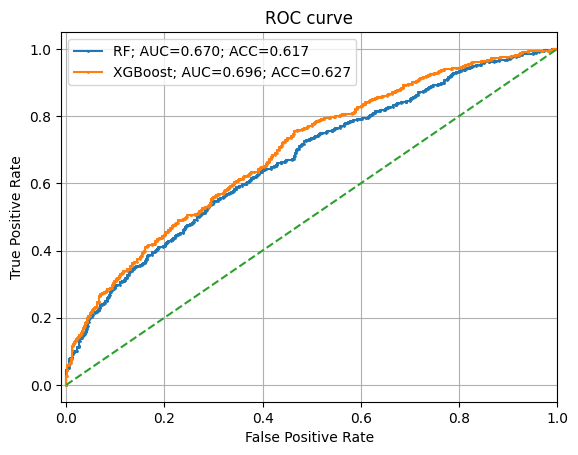

In [233]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb], ['RF', 'XGBoost'])

## NN

In [234]:
from torch import nn

In [235]:
N_epochs = 5000
stop_criteria = 200

### Raw features

In [241]:
def objective_nn_raw(trial):
    
    hidden_dim = trial.suggest_int('hidden_dim', 4, 2048, log=True)
    dropout = trial.suggest_float('dropout', 0, 0.99)
    model_raw = nn.Sequential(
        nn.BatchNorm1d(Xs['train'].shape[1]),
        FeedForwardMLPResidual(
            d_model=Xs['train'].shape[1], dim_feedforward=hidden_dim, dropout=dropout,
        ),
        nn.Linear(Xs['train'].shape[1], 1),
    )
    train_losses, test_losses, y_hat_raw = train(
        model_raw, Xs['train'], ys['train'], Xs['valid'], ys['valid'], Xs['test'], 
        N_epochs, stop_criteria=stop_criteria
    )
#     return test_losses[-1]
    return accuracy_score(ys['valid'], (model_raw(Xs['valid'])>=0.5).int())

In [242]:
study_nn_raw = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="eye-movement-nn_raw_v2",
    direction='maximize',
)  # Create a new study.
study_nn_raw.optimize(objective_nn_raw, n_trials=30)  # Invoke optimization of the objective function.

[I 2023-01-23 12:33:44,691] A new study created in RDB with name: eye-movement-nn_raw_v2
[I 2023-01-23 12:33:45,958] Trial 0 finished with value: 0.5964912280701754 and parameters: {'hidden_dim': 19, 'dropout': 0.7443786430970424}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 323 with valid acc 0.596


[I 2023-01-23 12:33:54,438] Trial 1 finished with value: 0.5833333333333334 and parameters: {'hidden_dim': 681, 'dropout': 0.8814066702408151}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 268 with valid acc 0.583


[I 2023-01-23 12:33:55,273] Trial 2 finished with value: 0.5921052631578947 and parameters: {'hidden_dim': 12, 'dropout': 0.22472980625274452}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 260 with valid acc 0.592


[I 2023-01-23 12:33:56,515] Trial 3 finished with value: 0.5745614035087719 and parameters: {'hidden_dim': 10, 'dropout': 0.9267562141655737}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 361 with valid acc 0.575


[I 2023-01-23 12:33:57,589] Trial 4 finished with value: 0.5818713450292398 and parameters: {'hidden_dim': 5, 'dropout': 0.6921529953385399}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 334 with valid acc 0.582


[I 2023-01-23 12:34:09,800] Trial 5 finished with value: 0.5935672514619883 and parameters: {'hidden_dim': 1166, 'dropout': 0.29503459808234744}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 267 with valid acc 0.594


[I 2023-01-23 12:34:11,104] Trial 6 finished with value: 0.5833333333333334 and parameters: {'hidden_dim': 4, 'dropout': 0.4705003835613499}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 414 with valid acc 0.583


[I 2023-01-23 12:34:28,259] Trial 7 finished with value: 0.5891812865497076 and parameters: {'hidden_dim': 1576, 'dropout': 0.9124648222344238}. Best is trial 0 with value: 0.5964912280701754.


Early stopping at epoch 294 with valid acc 0.589


[I 2023-01-23 12:34:35,056] Trial 8 finished with value: 0.6111111111111112 and parameters: {'hidden_dim': 447, 'dropout': 0.746288061141211}. Best is trial 8 with value: 0.6111111111111112.


Early stopping at epoch 339 with valid acc 0.611


[I 2023-01-23 12:34:36,629] Trial 9 finished with value: 0.5804093567251462 and parameters: {'hidden_dim': 59, 'dropout': 0.2560163390657318}. Best is trial 8 with value: 0.6111111111111112.


Early stopping at epoch 265 with valid acc 0.580


[I 2023-01-23 12:34:40,825] Trial 10 finished with value: 0.5804093567251462 and parameters: {'hidden_dim': 291, 'dropout': 0.017330603984238524}. Best is trial 8 with value: 0.6111111111111112.


Early stopping at epoch 251 with valid acc 0.580


[I 2023-01-23 12:34:46,122] Trial 11 finished with value: 0.6125730994152047 and parameters: {'hidden_dim': 84, 'dropout': 0.6947225479024758}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 731 with valid acc 0.613


[I 2023-01-23 12:34:49,571] Trial 12 finished with value: 0.597953216374269 and parameters: {'hidden_dim': 176, 'dropout': 0.6442373064432529}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 314 with valid acc 0.598


[I 2023-01-23 12:34:52,514] Trial 13 finished with value: 0.597953216374269 and parameters: {'hidden_dim': 72, 'dropout': 0.5717663693802654}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 467 with valid acc 0.598


[I 2023-01-23 12:34:56,923] Trial 14 finished with value: 0.6067251461988304 and parameters: {'hidden_dim': 329, 'dropout': 0.7683262242515707}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 243 with valid acc 0.607


[I 2023-01-23 12:35:02,586] Trial 15 finished with value: 0.6067251461988304 and parameters: {'hidden_dim': 135, 'dropout': 0.8075621094456977}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 601 with valid acc 0.607


[I 2023-01-23 12:35:05,144] Trial 16 finished with value: 0.5233918128654971 and parameters: {'hidden_dim': 38, 'dropout': 0.977651664260872}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 550 with valid acc 0.523


[I 2023-01-23 12:35:11,342] Trial 17 finished with value: 0.6023391812865497 and parameters: {'hidden_dim': 483, 'dropout': 0.5847877656652439}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 283 with valid acc 0.602


[I 2023-01-23 12:35:13,881] Trial 18 finished with value: 0.5935672514619883 and parameters: {'hidden_dim': 153, 'dropout': 0.8065227100815885}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 249 with valid acc 0.594


[I 2023-01-23 12:35:22,634] Trial 19 finished with value: 0.5921052631578947 and parameters: {'hidden_dim': 966, 'dropout': 0.6794608831258213}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 233 with valid acc 0.592


[I 2023-01-23 12:35:29,332] Trial 20 finished with value: 0.5862573099415205 and parameters: {'hidden_dim': 544, 'dropout': 0.5026980613232133}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 285 with valid acc 0.586


[I 2023-01-23 12:35:33,847] Trial 21 finished with value: 0.6125730994152047 and parameters: {'hidden_dim': 356, 'dropout': 0.8048659497539168}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 236 with valid acc 0.613


[I 2023-01-23 12:36:19,143] Trial 22 finished with value: 0.597953216374269 and parameters: {'hidden_dim': 1898, 'dropout': 0.8455403819848046}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 672 with valid acc 0.598


[I 2023-01-23 12:36:24,873] Trial 23 finished with value: 0.5964912280701754 and parameters: {'hidden_dim': 259, 'dropout': 0.7528060827839048}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 376 with valid acc 0.596


[I 2023-01-23 12:36:27,731] Trial 24 finished with value: 0.5891812865497076 and parameters: {'hidden_dim': 82, 'dropout': 0.9841319169790645}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 394 with valid acc 0.589


[I 2023-01-23 12:36:33,056] Trial 25 finished with value: 0.6023391812865497 and parameters: {'hidden_dim': 390, 'dropout': 0.8420827460947065}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 259 with valid acc 0.602


[I 2023-01-23 12:36:43,214] Trial 26 finished with value: 0.597953216374269 and parameters: {'hidden_dim': 787, 'dropout': 0.723269854730774}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 290 with valid acc 0.598


[I 2023-01-23 12:36:46,134] Trial 27 finished with value: 0.5804093567251462 and parameters: {'hidden_dim': 186, 'dropout': 0.6516597956350394}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 245 with valid acc 0.580


[I 2023-01-23 12:36:50,202] Trial 28 finished with value: 0.5964912280701754 and parameters: {'hidden_dim': 115, 'dropout': 0.8108327622694911}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 463 with valid acc 0.596


[I 2023-01-23 12:36:52,470] Trial 29 finished with value: 0.5950292397660819 and parameters: {'hidden_dim': 40, 'dropout': 0.7422488420279333}. Best is trial 11 with value: 0.6125730994152047.


Early stopping at epoch 479 with valid acc 0.595


In [243]:
best_params_nn_raw = study_nn_raw.best_params
best_params_nn_raw

{'dropout': 0.6947225479024758, 'hidden_dim': 84}

In [245]:
hidden_dim = best_params_nn_raw['hidden_dim']
dropout = best_params_nn_raw['dropout']

model_raw = nn.Sequential(
    nn.BatchNorm1d(Xs['train'].shape[1]),
    FeedForwardMLPResidual(
        d_model=Xs['train'].shape[1], dim_feedforward=hidden_dim, dropout=dropout,
    ),
    nn.Linear(Xs['train'].shape[1], 1),
)

In [246]:
sum([p.numel() for p in model_raw.parameters()])

3565

In [247]:
train_losses, test_losses, y_hat_raw = train(
    model_raw, Xs['train'], ys['train'], Xs['valid'], ys['valid'], Xs['test'], 
    N_epochs, stop_criteria=stop_criteria
)

Early stopping at epoch 381 with valid acc 0.607


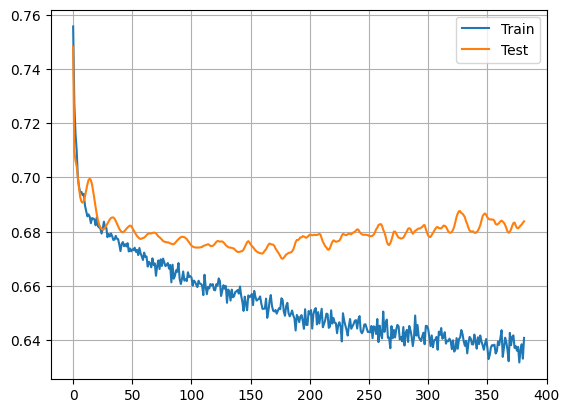

In [248]:
plot_losses(train_losses, test_losses)

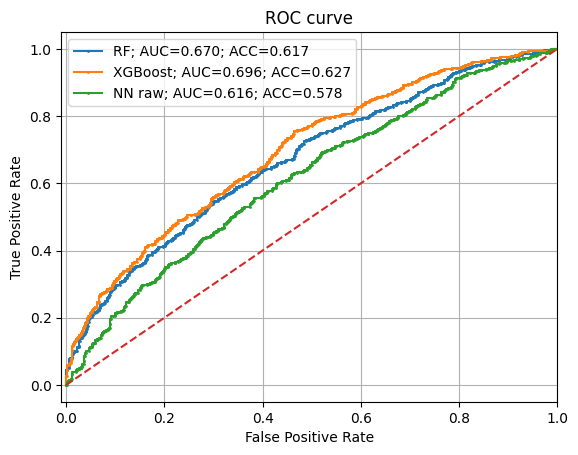

In [249]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw], ['RF', 'XGBoost', 'NN raw'])

### Single-feature DTE
Grow trees on a single feature at a time.

In [250]:
# eye-movement min_impurity_decrease=1e-4
Xs_dt, decision_trees, leaf_encoders = decision_tree_encoding(Xs, ys, min_impurity_decrease=1e-4)#, max_splits=20)

In [251]:
n_uniques = (Xs_dt['train'].max(dim=0)[0]+1).numpy()
n_uniques

array([1013,  117,   10,   19,   29,   16, 1004, 1067,  884,  684,  848,
         20,   13,  125,   85,  705,  644,  173,    9,    7])

In [280]:
def objective_dte(trial):
    embed_dim = trial.suggest_int('embed_dim', 1, 32) # 1
    hidden_dim = 512 # trial.suggest_int('hidden_dim', 8, 2048, log=True)
    dropout_embed = 0.16 # trial.suggest_float('dropout_embed', 0, 0.5)
    dropout_ffn = trial.suggest_float('dropout_ffn', 0, 0.5)
    l1_lambda = 4e-4 # trial.suggest_float('l1_lambda', 1e-5, 1e-2, log=True)
    model_dt = nn.Sequential(
        NumericEmbedding(n_uniques, embed_dim, 'concat'),
        nn.Dropout(dropout_embed),
        FeedForwardMLPResidual(
            d_model=n_uniques.shape[0]*embed_dim, dim_feedforward=hidden_dim, dropout=dropout_ffn,
        ),
        nn.Linear(n_uniques.shape[0]*embed_dim, 1),
    )
    train_losses_dt, test_losses_dt, y_hat_dt = train(
        model_dt, Xs_dt['train'], ys['train'], Xs_dt['valid'], ys['valid'], Xs_dt['test'], 
        N_epochs, 
        stop_criteria=stop_criteria, 
        l1_lambda=l1_lambda,
    )
    return accuracy_score(ys['valid'], (model_dt(Xs_dt['valid'])>=0.5).int())

In [281]:
study_dte = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="eye-movement-dte_v4",
    direction='maximize',
)  # Create a new study.
study_dte.optimize(objective_dte, n_trials=30)  # Invoke optimization of the objective function.

[I 2023-01-23 13:33:58,318] A new study created in RDB with name: eye-movement-dte_v4
[I 2023-01-23 13:34:17,129] Trial 0 finished with value: 0.72953216374269 and parameters: {'embed_dim': 9, 'dropout_ffn': 0.48932510781432187}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 415 with valid acc 0.730


[I 2023-01-23 13:34:40,239] Trial 1 finished with value: 0.7251461988304093 and parameters: {'embed_dim': 12, 'dropout_ffn': 0.2882921345492424}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 444 with valid acc 0.725


[I 2023-01-23 13:35:02,553] Trial 2 finished with value: 0.7222222222222222 and parameters: {'embed_dim': 6, 'dropout_ffn': 0.26360880621593297}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 576 with valid acc 0.722


[I 2023-01-23 13:35:35,117] Trial 3 finished with value: 0.7280701754385965 and parameters: {'embed_dim': 20, 'dropout_ffn': 0.1990278167839561}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 521 with valid acc 0.728


[I 2023-01-23 13:36:04,677] Trial 4 finished with value: 0.7280701754385965 and parameters: {'embed_dim': 20, 'dropout_ffn': 0.28703563929732284}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 469 with valid acc 0.728


[I 2023-01-23 13:36:30,019] Trial 5 finished with value: 0.7119883040935673 and parameters: {'embed_dim': 14, 'dropout_ffn': 0.4013084840550264}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 451 with valid acc 0.712


[I 2023-01-23 13:37:09,541] Trial 6 finished with value: 0.716374269005848 and parameters: {'embed_dim': 12, 'dropout_ffn': 0.059043378244295674}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 768 with valid acc 0.716


[I 2023-01-23 13:37:52,765] Trial 7 finished with value: 0.7266081871345029 and parameters: {'embed_dim': 21, 'dropout_ffn': 0.3934226042076261}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 654 with valid acc 0.727


[I 2023-01-23 13:38:42,626] Trial 8 finished with value: 0.7119883040935673 and parameters: {'embed_dim': 26, 'dropout_ffn': 0.24478844129927085}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 671 with valid acc 0.712


[I 2023-01-23 13:38:56,518] Trial 9 finished with value: 0.7192982456140351 and parameters: {'embed_dim': 4, 'dropout_ffn': 0.1842910890393184}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 417 with valid acc 0.719


[I 2023-01-23 13:39:45,824] Trial 10 finished with value: 0.6944444444444444 and parameters: {'embed_dim': 32, 'dropout_ffn': 0.49113333601029724}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 618 with valid acc 0.694


[I 2023-01-23 13:40:03,452] Trial 11 finished with value: 0.716374269005848 and parameters: {'embed_dim': 8, 'dropout_ffn': 0.13223936063464586}. Best is trial 0 with value: 0.72953216374269.


Early stopping at epoch 420 with valid acc 0.716


[I 2023-01-23 13:40:43,671] Trial 12 finished with value: 0.7383040935672515 and parameters: {'embed_dim': 19, 'dropout_ffn': 0.05423667974119023}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 628 with valid acc 0.738


[I 2023-01-23 13:40:55,064] Trial 13 finished with value: 0.6842105263157895 and parameters: {'embed_dim': 2, 'dropout_ffn': 0.012879356881009107}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 401 with valid acc 0.684


[I 2023-01-23 13:41:25,569] Trial 14 finished with value: 0.7266081871345029 and parameters: {'embed_dim': 9, 'dropout_ffn': 0.08536947172292253}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 676 with valid acc 0.727


[I 2023-01-23 13:41:56,742] Trial 15 finished with value: 0.7251461988304093 and parameters: {'embed_dim': 16, 'dropout_ffn': 0.0009884038795232516}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 545 with valid acc 0.725


[I 2023-01-23 13:43:01,621] Trial 16 finished with value: 0.706140350877193 and parameters: {'embed_dim': 26, 'dropout_ffn': 0.11193563180695157}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 856 with valid acc 0.706


[I 2023-01-23 13:43:35,262] Trial 17 finished with value: 0.7002923976608187 and parameters: {'embed_dim': 25, 'dropout_ffn': 0.14888876641636592}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 462 with valid acc 0.700


[I 2023-01-23 13:44:13,749] Trial 18 finished with value: 0.7251461988304093 and parameters: {'embed_dim': 18, 'dropout_ffn': 0.06936626874382815}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 627 with valid acc 0.725


[I 2023-01-23 13:44:36,263] Trial 19 finished with value: 0.7236842105263158 and parameters: {'embed_dim': 10, 'dropout_ffn': 0.3422850987875314}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 482 with valid acc 0.724


[I 2023-01-23 13:44:47,318] Trial 20 finished with value: 0.672514619883041 and parameters: {'embed_dim': 1, 'dropout_ffn': 0.4846539856687885}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 428 with valid acc 0.673


[I 2023-01-23 13:45:27,872] Trial 21 finished with value: 0.7178362573099415 and parameters: {'embed_dim': 21, 'dropout_ffn': 0.1875185013195209}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 619 with valid acc 0.718


[I 2023-01-23 13:45:58,558] Trial 22 finished with value: 0.7280701754385965 and parameters: {'embed_dim': 16, 'dropout_ffn': 0.21210005602247564}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 528 with valid acc 0.728


[I 2023-01-23 13:46:54,185] Trial 23 finished with value: 0.7324561403508771 and parameters: {'embed_dim': 23, 'dropout_ffn': 0.15704886095683795}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 817 with valid acc 0.732


[I 2023-01-23 13:47:41,454] Trial 24 finished with value: 0.7134502923976608 and parameters: {'embed_dim': 29, 'dropout_ffn': 0.15708522110754686}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 577 with valid acc 0.713


[I 2023-01-23 13:48:25,052] Trial 25 finished with value: 0.7236842105263158 and parameters: {'embed_dim': 23, 'dropout_ffn': 0.09961826013976796}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 648 with valid acc 0.724


[I 2023-01-23 13:49:06,084] Trial 26 finished with value: 0.7339181286549707 and parameters: {'embed_dim': 18, 'dropout_ffn': 0.04365235138874888}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 655 with valid acc 0.734


[I 2023-01-23 13:49:48,585] Trial 27 finished with value: 0.7178362573099415 and parameters: {'embed_dim': 23, 'dropout_ffn': 0.037329814209985115}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 628 with valid acc 0.718


[I 2023-01-23 13:50:28,375] Trial 28 finished with value: 0.7119883040935673 and parameters: {'embed_dim': 18, 'dropout_ffn': 0.04325337962698303}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 638 with valid acc 0.712


[I 2023-01-23 13:50:56,363] Trial 29 finished with value: 0.7105263157894737 and parameters: {'embed_dim': 14, 'dropout_ffn': 0.10040654860201288}. Best is trial 12 with value: 0.7383040935672515.


Early stopping at epoch 502 with valid acc 0.711


In [282]:
best_params_dte = study_dte.best_params
best_params_dte

{'dropout_ffn': 0.05423667974119023, 'embed_dim': 19}

In [283]:
embed_dim = best_params_dte['embed_dim'] #1
hidden_dim = 512 # best_params_dte['hidden_dim'] # 1028
dropout_embed = 0.16 # best_params_dte['dropout_embed'] # 0.1
dropout_ffn = best_params_dte['dropout_ffn'] # 0.1

model_dt = nn.Sequential(
    NumericEmbedding(n_uniques, embed_dim, 'concat'),
    nn.Dropout(dropout_embed),
    FeedForwardMLPResidual(
        d_model=n_uniques.shape[0]*embed_dim, dim_feedforward=hidden_dim, dropout=dropout_ffn,
    ),
    nn.Linear(n_uniques.shape[0]*embed_dim, 1),
)

In [284]:
sum([p.numel() for p in model_dt.parameters()])

533121

In [285]:
train_losses_dt, test_losses_dt, y_hat_dt = train(
    model_dt, Xs_dt['train'], ys['train'], Xs_dt['valid'], ys['valid'], Xs_dt['test'], 
    N_epochs, 
    stop_criteria=stop_criteria, 
    l1_lambda=4e-4,
)

Early stopping at epoch 661 with valid acc 0.734


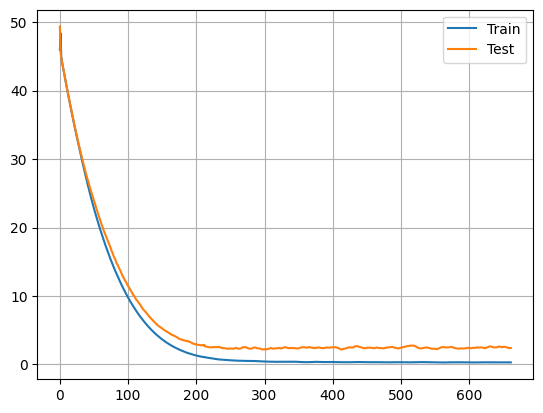

In [286]:
plot_losses(train_losses_dt, test_losses_dt)

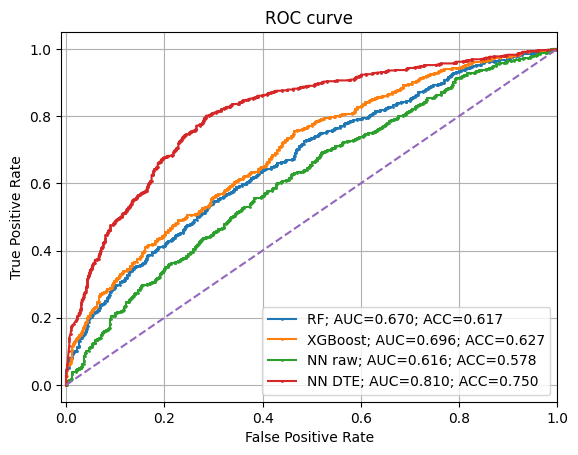

In [287]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt], ['RF', 'XGBoost', 'NN raw', 'NN DTE'])

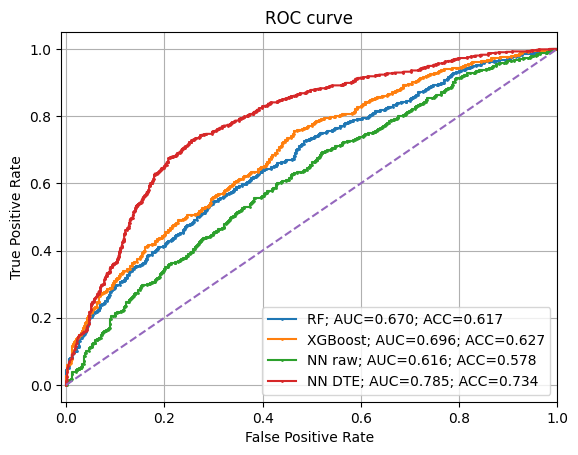

In [279]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt], ['RF', 'XGBoost', 'NN raw', 'NN DTE'])

### Multi-feature DTEs
Learn embeddings for leaves of trees grown on more than one feature at a time.

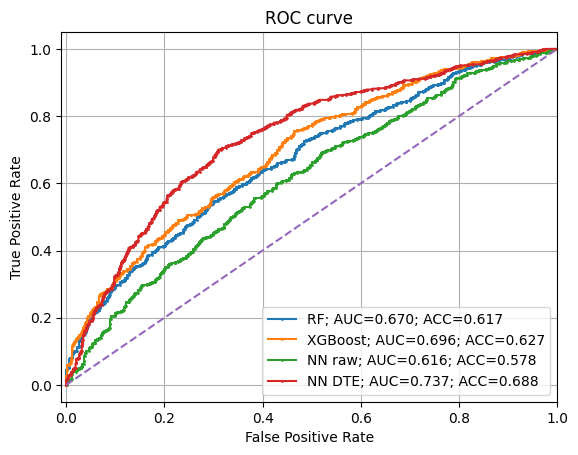

In [267]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt], ['RF', 'XGBoost', 'NN raw', 'NN DTE'])

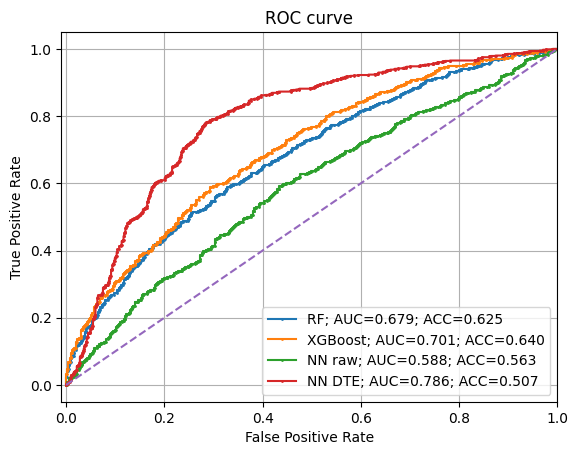

In [168]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt], ['RF', 'XGBoost', 'NN raw', 'NN DTE'])

### On top of existing RF

In [303]:
tree_kwargs = dict(
    n_estimators=20,
#     learning_rate=0.1,
#     subsample=0.25,
#     max_samples=1000,
#     max_features=2,
    max_depth=10,
#     max_leaf_nodes=100,
)
Xs_dtm, decision_trees_m, leaf_encoders_m = decision_tree_encoding_multi(
    Xs, ys, mode='classification', tree_kwargs=tree_kwargs)

In [304]:
n_uniques_multi = (Xs_dtm['train'].max(dim=0)[0]+1).numpy()
n_uniques_multi

array([298, 297, 272, 298, 269, 221, 224, 270, 245, 259, 278, 288, 215,
       238, 323, 190, 257, 256, 282, 240])

In [291]:
def objective_dte_multi(trial):
    embed_dim = trial.suggest_int('embed_dim', 1, 32) # 1
    dropout_embed = trial.suggest_float('dropout_embed', 0, 0.99)
    dropout_ffn = trial.suggest_float('dropout_ffn', 0, 0.99)
    l1_lambda = trial.suggest_float('l1_lambda', 1e-5, 1e-2, log=True)
    
    hidden_dim = 512 # trial.suggest_int('hidden_dim', 8, 2048, log=True) # 1024
    
    model_dt_multi = nn.Sequential(
        NumericEmbedding(n_uniques_multi, embed_dim, 'concat'),
        nn.Dropout(dropout_embed),
        FeedForwardMLPResidual(
            d_model=n_uniques_multi.shape[0]*embed_dim, 
            dim_feedforward=hidden_dim, dropout=dropout_ffn,
        ),
        nn.Linear(
            n_uniques_multi.shape[0]*embed_dim, 1
        ),
    )
    train_losses_dtm, test_losses_dtm, y_hat_dtm = train(
        model_dt_multi, Xs_dtm['train'], ys['train'], Xs_dtm['valid'], ys['valid'], Xs_dtm['test'], 
        N_epochs, 
        stop_criteria=stop_criteria, 
        l1_lambda=l1_lambda,
    )
    return accuracy_score(ys['valid'], (model_dt_multi(Xs_dtm['valid'])>=0.5).int())

In [292]:
study_dtem = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="eye-movement-dte-multi_v2",
    direction='maximize',
)  # Create a new study.
study_dtem.optimize(objective_dte_multi, n_trials=30)  # Invoke optimization of the objective function.

[I 2023-01-23 13:57:17,167] A new study created in RDB with name: eye-movement-dte-multi_v2
[I 2023-01-23 13:58:20,458] Trial 0 finished with value: 0.6198830409356725 and parameters: {'embed_dim': 12, 'dropout_embed': 0.8391659470564684, 'dropout_ffn': 0.1016109862544196, 'l1_lambda': 0.0001022415635507743}. Best is trial 0 with value: 0.6198830409356725.


Early stopping at epoch 370 with valid acc 0.620


[I 2023-01-23 13:59:15,597] Trial 1 finished with value: 0.5921052631578947 and parameters: {'embed_dim': 19, 'dropout_embed': 0.4252124043340829, 'dropout_ffn': 0.4923925145529588, 'l1_lambda': 0.0005127700179838561}. Best is trial 0 with value: 0.6198830409356725.


Early stopping at epoch 232 with valid acc 0.592


[I 2023-01-23 14:01:45,606] Trial 2 finished with value: 0.6271929824561403 and parameters: {'embed_dim': 19, 'dropout_embed': 0.9192440743993509, 'dropout_ffn': 0.6898975716191538, 'l1_lambda': 0.007022177558055284}. Best is trial 2 with value: 0.6271929824561403.


Early stopping at epoch 647 with valid acc 0.627


[I 2023-01-23 14:02:32,425] Trial 3 finished with value: 0.5921052631578947 and parameters: {'embed_dim': 16, 'dropout_embed': 0.8263925437122491, 'dropout_ffn': 0.18942398425431342, 'l1_lambda': 0.005326077425653372}. Best is trial 2 with value: 0.6271929824561403.


Early stopping at epoch 243 with valid acc 0.592


[I 2023-01-23 14:03:43,500] Trial 4 finished with value: 0.6125730994152047 and parameters: {'embed_dim': 20, 'dropout_embed': 0.8872102097339555, 'dropout_ffn': 0.9343790253354584, 'l1_lambda': 1.3286725751747005e-05}. Best is trial 2 with value: 0.6271929824561403.


Early stopping at epoch 301 with valid acc 0.613


[I 2023-01-23 14:04:49,890] Trial 5 finished with value: 0.6008771929824561 and parameters: {'embed_dim': 15, 'dropout_embed': 0.7574267486301441, 'dropout_ffn': 0.4127209914201123, 'l1_lambda': 1.0160317130962444e-05}. Best is trial 2 with value: 0.6271929824561403.


Early stopping at epoch 340 with valid acc 0.601


[I 2023-01-23 14:07:09,834] Trial 6 finished with value: 0.6228070175438597 and parameters: {'embed_dim': 23, 'dropout_embed': 0.5717708783361551, 'dropout_ffn': 0.181934301703699, 'l1_lambda': 0.00011642904142991933}. Best is trial 2 with value: 0.6271929824561403.


Early stopping at epoch 533 with valid acc 0.623


[I 2023-01-23 14:08:31,062] Trial 7 finished with value: 0.6359649122807017 and parameters: {'embed_dim': 9, 'dropout_embed': 0.9519670941596402, 'dropout_ffn': 0.8678585268761276, 'l1_lambda': 0.0009473139294008016}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 595 with valid acc 0.636


[I 2023-01-23 14:10:02,136] Trial 8 finished with value: 0.6228070175438597 and parameters: {'embed_dim': 17, 'dropout_embed': 0.9545207352232301, 'dropout_ffn': 0.5894216105790577, 'l1_lambda': 0.00028207136759265277}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 445 with valid acc 0.623


[I 2023-01-23 14:10:57,033] Trial 9 finished with value: 0.6096491228070176 and parameters: {'embed_dim': 19, 'dropout_embed': 0.4593661301624864, 'dropout_ffn': 0.6752213215890407, 'l1_lambda': 5.8262919966716324e-05}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 245 with valid acc 0.610


[I 2023-01-23 14:11:13,915] Trial 10 finished with value: 0.5277777777777778 and parameters: {'embed_dim': 1, 'dropout_embed': 0.09924794424247807, 'dropout_ffn': 0.9870079097066915, 'l1_lambda': 0.0014499152278765876}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 295 with valid acc 0.528


[I 2023-01-23 14:12:42,930] Trial 11 finished with value: 0.5804093567251462 and parameters: {'embed_dim': 30, 'dropout_embed': 0.9744595626999133, 'dropout_ffn': 0.7873115160057909, 'l1_lambda': 0.009349603609985081}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 272 with valid acc 0.580


[I 2023-01-23 14:13:16,445] Trial 12 finished with value: 0.5891812865497076 and parameters: {'embed_dim': 8, 'dropout_embed': 0.705756953599933, 'dropout_ffn': 0.8024183187650861, 'l1_lambda': 0.0026275686861630537}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 269 with valid acc 0.589


[I 2023-01-23 14:14:10,194] Trial 13 finished with value: 0.6271929824561403 and parameters: {'embed_dim': 6, 'dropout_embed': 0.9809381544650282, 'dropout_ffn': 0.7746416253540032, 'l1_lambda': 0.0013699544212871927}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 482 with valid acc 0.627


[I 2023-01-23 14:15:20,611] Trial 14 finished with value: 0.6067251461988304 and parameters: {'embed_dim': 26, 'dropout_embed': 0.6750023311827267, 'dropout_ffn': 0.8735995270111376, 'l1_lambda': 0.004297214450015804}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 237 with valid acc 0.607


[I 2023-01-23 14:15:57,386] Trial 15 finished with value: 0.6096491228070176 and parameters: {'embed_dim': 9, 'dropout_embed': 0.8398300316849887, 'dropout_ffn': 0.6884290966471359, 'l1_lambda': 0.008067166250014253}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 269 with valid acc 0.610


[I 2023-01-23 14:16:34,049] Trial 16 finished with value: 0.6052631578947368 and parameters: {'embed_dim': 1, 'dropout_embed': 0.6074759260552665, 'dropout_ffn': 0.8763897701628331, 'l1_lambda': 0.002595200271979189}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 635 with valid acc 0.605


[I 2023-01-23 14:17:11,197] Trial 17 finished with value: 0.5365497076023392 and parameters: {'embed_dim': 12, 'dropout_embed': 0.7756647562675707, 'dropout_ffn': 0.9892485757003171, 'l1_lambda': 0.0008199423252197519}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 222 with valid acc 0.537


[I 2023-01-23 14:18:20,827] Trial 18 finished with value: 0.6213450292397661 and parameters: {'embed_dim': 24, 'dropout_embed': 0.9044458112509812, 'dropout_ffn': 0.6429047556300396, 'l1_lambda': 0.002886486162373452}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 261 with valid acc 0.621


[I 2023-01-23 14:18:47,824] Trial 19 finished with value: 0.5964912280701754 and parameters: {'embed_dim': 5, 'dropout_embed': 0.987103673362481, 'dropout_ffn': 0.552907002397895, 'l1_lambda': 0.0013346005625896383}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 258 with valid acc 0.596


[I 2023-01-23 14:19:57,066] Trial 20 finished with value: 0.6081871345029239 and parameters: {'embed_dim': 12, 'dropout_embed': 0.7478059525044215, 'dropout_ffn': 0.7368470717563856, 'l1_lambda': 0.009581978537267007}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 418 with valid acc 0.608


[I 2023-01-23 14:21:11,427] Trial 21 finished with value: 0.6242690058479532 and parameters: {'embed_dim': 7, 'dropout_embed': 0.8930613592047648, 'dropout_ffn': 0.8129708857177553, 'l1_lambda': 0.0013693573205692032}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 627 with valid acc 0.624


[I 2023-01-23 14:22:20,583] Trial 22 finished with value: 0.6345029239766082 and parameters: {'embed_dim': 4, 'dropout_embed': 0.9793854821289028, 'dropout_ffn': 0.8646390932350974, 'l1_lambda': 0.0007028413543463076}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 782 with valid acc 0.635


[I 2023-01-23 14:23:26,559] Trial 23 finished with value: 0.6228070175438597 and parameters: {'embed_dim': 4, 'dropout_embed': 0.8865744244750413, 'dropout_ffn': 0.8761058379747333, 'l1_lambda': 0.0004223163039815801}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 745 with valid acc 0.623


[I 2023-01-23 14:23:49,344] Trial 24 finished with value: 0.6096491228070176 and parameters: {'embed_dim': 3, 'dropout_embed': 0.8097255038046742, 'dropout_ffn': 0.720044128988443, 'l1_lambda': 0.0007161678317189181}. Best is trial 7 with value: 0.6359649122807017.


Early stopping at epoch 274 with valid acc 0.610


[I 2023-01-23 14:25:59,782] Trial 25 finished with value: 0.6388888888888888 and parameters: {'embed_dim': 10, 'dropout_embed': 0.9872748145117225, 'dropout_ffn': 0.8798830637058427, 'l1_lambda': 0.00027207115200156105}. Best is trial 25 with value: 0.6388888888888888.


Early stopping at epoch 912 with valid acc 0.639


[I 2023-01-23 14:27:38,238] Trial 26 finished with value: 0.6198830409356725 and parameters: {'embed_dim': 9, 'dropout_embed': 0.9219761185885005, 'dropout_ffn': 0.9061808507286353, 'l1_lambda': 0.0002814404585424418}. Best is trial 25 with value: 0.6388888888888888.


Early stopping at epoch 720 with valid acc 0.620


[I 2023-01-23 14:29:25,859] Trial 27 finished with value: 0.6345029239766082 and parameters: {'embed_dim': 11, 'dropout_embed': 0.9862999121729032, 'dropout_ffn': 0.8404777855248327, 'l1_lambda': 0.000286909488603957}. Best is trial 25 with value: 0.6388888888888888.


Early stopping at epoch 661 with valid acc 0.635


[I 2023-01-23 14:31:13,383] Trial 28 finished with value: 0.6096491228070176 and parameters: {'embed_dim': 14, 'dropout_embed': 0.8293408710167698, 'dropout_ffn': 0.9217086826363065, 'l1_lambda': 0.0006943375725656884}. Best is trial 25 with value: 0.6388888888888888.


Early stopping at epoch 572 with valid acc 0.610


[I 2023-01-23 14:32:22,309] Trial 29 finished with value: 0.6169590643274854 and parameters: {'embed_dim': 10, 'dropout_embed': 0.8641258283718914, 'dropout_ffn': 0.8223789837889882, 'l1_lambda': 0.0001765872446256393}. Best is trial 25 with value: 0.6388888888888888.


Early stopping at epoch 478 with valid acc 0.617


In [293]:
best_params_dtem = study_dtem.best_params
best_params_dtem

{'dropout_embed': 0.9872748145117225,
 'dropout_ffn': 0.8798830637058427,
 'embed_dim': 10,
 'l1_lambda': 0.00027207115200156105}

In [294]:
embed_dim = best_params_dtem['embed_dim'] # 1
hidden_dim = 512 # best_params_dtem['hidden_dim']
dropout_embed = best_params_dtem['dropout_embed']
dropout_ffn = best_params_dtem['dropout_ffn']

model_dt_multi = nn.Sequential(
    NumericEmbedding(n_uniques_multi, embed_dim, 'concat'),
    nn.Dropout(dropout),
    FeedForwardMLPResidual(
        d_model=n_uniques_multi.shape[0]*embed_dim, 
        dim_feedforward=hidden_dim, dropout=dropout,
    ),
    nn.Linear(
        n_uniques_multi.shape[0]*embed_dim, 1
    ),
)

In [295]:
# model_dt_multi

In [296]:
sum([p.numel() for p in model_dt_multi.parameters()])

1299093

In [297]:
train_losses_dtm, test_losses_dtm, y_hat_dtm = train(
    model_dt_multi, Xs_dtm['train'], ys['train'], Xs_dtm['valid'], ys['valid'], Xs_dtm['test'], 
    N_epochs, 
    stop_criteria=stop_criteria, 
    l1_lambda=best_params_dtem['l1_lambda'], #1e-3,
)

Early stopping at epoch 470 with valid acc 0.630


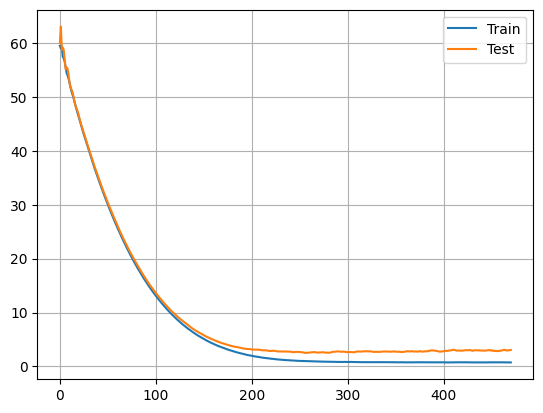

In [298]:
plot_losses(train_losses_dtm, test_losses_dtm)

In [299]:
# plot_roc(ys['valid'],[model_dt_multi(Xs_dtm['valid']).flatten().sigmoid().detach().numpy()], ['NN DTE-m - valid'])

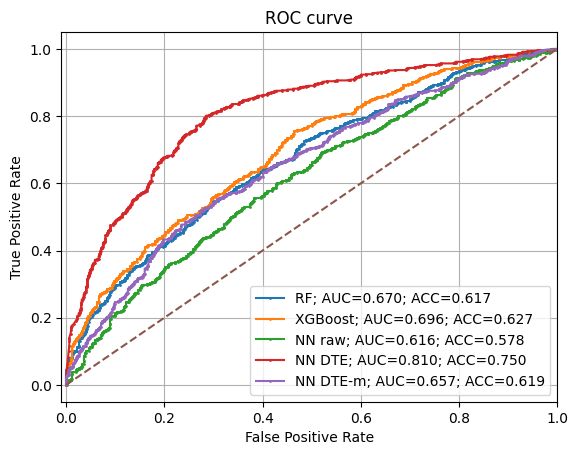

In [302]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, y_hat_dtm], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'NN DTE-m']
)

In [181]:
from sklearn.preprocessing import OrdinalEncoder

#### Random Forest

In [308]:
le_rf = OrdinalEncoder()
le_rf.fit(clf_rf.apply(Xs['train']))

OrdinalEncoder()

In [309]:
Xs_dtrf = {key: th.tensor(le_rf.transform(clf_rf.apply(Xs[key]))).long() for key in Xs.keys()}

In [310]:
n_uniques_rf = (Xs_dtrf['train'].max(dim=0)[0]+1).numpy()
n_uniques_rf

array([281, 245, 295, 304, 304, 313, 220, 313, 283, 170, 276, 217, 205,
       309, 238, 244, 197, 205, 222, 231, 308, 286, 272, 187, 290, 221,
       343, 269, 220, 269, 258, 329, 255, 233, 226, 232, 270, 245, 250,
       272, 251, 292, 246, 293, 250, 245, 296, 247, 296, 241, 299, 267,
       216, 244, 270, 220, 200, 278, 266, 307, 268, 266, 247, 304, 261,
       291, 258, 290, 303, 228, 246, 305, 248, 273, 280, 234, 246, 203,
       129, 295, 227, 302, 238, 252, 298, 254, 204, 283, 318, 295, 222,
       233, 288, 234, 250, 304, 255, 246, 233, 289, 269, 230, 193, 278,
       286, 195, 232, 273, 264, 248, 285, 291, 246, 232, 276, 314, 266,
       272, 312, 283, 280, 326, 176, 285, 308, 270])

In [311]:
def objective_rf_nn(trial):
    embed_dim = trial.suggest_int('embed_dim', 2, 256, log=True) # 8 
    hidden_dim = trial.suggest_int('hidden_dim', 8, 1024, log=True) # 256
    dropout_embed = trial.suggest_float('dropout_embed', 0, 0.99) # 0.1
    dropout_ffn = trial.suggest_float('dropout_ffn', 0, 0.99) # 0.1
    model_dt_rf = nn.Sequential(
        NumericEmbedding(n_uniques_rf, embed_dim, 'sum'),
        nn.Dropout(dropout_embed),
        FeedForwardMLPResidual(
            d_model=embed_dim,
            dim_feedforward=hidden_dim, dropout=dropout_ffn,
        ),
        nn.Linear(embed_dim, 1),
    )
    train_losses_dtrf, test_losses_dtrf, y_hat_dtrf = train(
        model_dt_rf, Xs_dtrf['train'], ys['train'], Xs_dtrf['valid'], ys['valid'], Xs_dtrf['test'], 
        N_epochs, 
        stop_criteria=stop_criteria, 
        l1_lambda=4e-4,
    )
    return accuracy_score(ys['valid'], (model_dt_rf(Xs_dtrf['valid'])>=0.5).int())

In [312]:
study_rf_nn = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="eye-movement-rf_nn_v4",
    direction='maximize',
)  # Create a new study.
study_rf_nn.optimize(objective_rf_nn, n_trials=30)  # Invoke optimization of the objective function.

[I 2023-01-23 15:19:27,518] A new study created in RDB with name: eye-movement-rf_nn_v4
[I 2023-01-23 15:19:48,950] Trial 0 finished with value: 0.5789473684210527 and parameters: {'embed_dim': 4, 'hidden_dim': 28, 'dropout_embed': 0.09998936389428408, 'dropout_ffn': 0.9295403562193357}. Best is trial 0 with value: 0.5789473684210527.


Early stopping at epoch 525 with valid acc 0.579


[I 2023-01-23 15:19:59,293] Trial 1 finished with value: 0.5277777777777778 and parameters: {'embed_dim': 2, 'hidden_dim': 331, 'dropout_embed': 0.7281758934160245, 'dropout_ffn': 0.9889108385063813}. Best is trial 0 with value: 0.5789473684210527.


Early stopping at epoch 201 with valid acc 0.528


[I 2023-01-23 15:21:32,804] Trial 2 finished with value: 0.5964912280701754 and parameters: {'embed_dim': 68, 'hidden_dim': 409, 'dropout_embed': 0.8328337178267687, 'dropout_ffn': 0.10934472249971575}. Best is trial 2 with value: 0.5964912280701754.


Early stopping at epoch 439 with valid acc 0.596


[I 2023-01-23 15:21:42,264] Trial 3 finished with value: 0.5307017543859649 and parameters: {'embed_dim': 4, 'hidden_dim': 13, 'dropout_embed': 0.506352546527956, 'dropout_ffn': 0.9023501096616318}. Best is trial 2 with value: 0.5964912280701754.


Early stopping at epoch 219 with valid acc 0.531


[I 2023-01-23 15:22:58,791] Trial 4 finished with value: 0.5964912280701754 and parameters: {'embed_dim': 36, 'hidden_dim': 15, 'dropout_embed': 0.8141571196178252, 'dropout_ffn': 0.003078433076941869}. Best is trial 2 with value: 0.5964912280701754.


Early stopping at epoch 636 with valid acc 0.596


[I 2023-01-23 15:23:11,308] Trial 5 finished with value: 0.5277777777777778 and parameters: {'embed_dim': 10, 'hidden_dim': 23, 'dropout_embed': 0.8654316677770358, 'dropout_ffn': 0.9893531699717965}. Best is trial 2 with value: 0.5964912280701754.


Early stopping at epoch 212 with valid acc 0.528


[I 2023-01-23 15:23:35,345] Trial 6 finished with value: 0.5921052631578947 and parameters: {'embed_dim': 17, 'hidden_dim': 23, 'dropout_embed': 0.016781958879049864, 'dropout_ffn': 0.5234489913287542}. Best is trial 2 with value: 0.5964912280701754.


Early stopping at epoch 348 with valid acc 0.592


[I 2023-01-23 15:24:07,471] Trial 7 finished with value: 0.5935672514619883 and parameters: {'embed_dim': 11, 'hidden_dim': 443, 'dropout_embed': 0.07728734841256514, 'dropout_ffn': 0.7184943872563363}. Best is trial 2 with value: 0.5964912280701754.


Early stopping at epoch 399 with valid acc 0.594


[I 2023-01-23 15:24:18,565] Trial 8 finished with value: 0.5277777777777778 and parameters: {'embed_dim': 2, 'hidden_dim': 280, 'dropout_embed': 0.3181165258877763, 'dropout_ffn': 0.4012874132137848}. Best is trial 2 with value: 0.5964912280701754.


Early stopping at epoch 207 with valid acc 0.528


[I 2023-01-23 15:28:00,586] Trial 9 finished with value: 0.6052631578947368 and parameters: {'embed_dim': 112, 'hidden_dim': 39, 'dropout_embed': 0.27702489190170765, 'dropout_ffn': 0.8803402966445557}. Best is trial 9 with value: 0.6052631578947368.


Early stopping at epoch 683 with valid acc 0.605


[I 2023-01-23 15:32:13,547] Trial 10 finished with value: 0.5921052631578947 and parameters: {'embed_dim': 229, 'hidden_dim': 73, 'dropout_embed': 0.3353379404859462, 'dropout_ffn': 0.7465301607354167}. Best is trial 9 with value: 0.6052631578947368.


Early stopping at epoch 382 with valid acc 0.592


[I 2023-01-23 15:35:09,548] Trial 11 finished with value: 0.5994152046783626 and parameters: {'embed_dim': 103, 'hidden_dim': 120, 'dropout_embed': 0.6976135542590213, 'dropout_ffn': 0.10525443995977624}. Best is trial 9 with value: 0.6052631578947368.


Early stopping at epoch 585 with valid acc 0.599


[I 2023-01-23 15:38:02,520] Trial 12 finished with value: 0.6081871345029239 and parameters: {'embed_dim': 122, 'hidden_dim': 89, 'dropout_embed': 0.6474699185515934, 'dropout_ffn': 0.21317576023090995}. Best is trial 12 with value: 0.6081871345029239.


Early stopping at epoch 465 with valid acc 0.608
Early stopping at epoch 582 with valid acc 0.633


[I 2023-01-23 15:44:56,284] Trial 13 finished with value: 0.6330409356725146 and parameters: {'embed_dim': 254, 'hidden_dim': 62, 'dropout_embed': 0.9765054703919771, 'dropout_ffn': 0.34137559746920754}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 228 with valid acc 0.550


[I 2023-01-23 15:47:44,365] Trial 14 finished with value: 0.5497076023391813 and parameters: {'embed_dim': 244, 'hidden_dim': 1002, 'dropout_embed': 0.9730339968890461, 'dropout_ffn': 0.3362536018247962}. Best is trial 13 with value: 0.6330409356725146.
[I 2023-01-23 15:49:18,642] Trial 15 finished with value: 0.6111111111111112 and parameters: {'embed_dim': 46, 'hidden_dim': 8, 'dropout_embed': 0.5792301803837888, 'dropout_ffn': 0.2573634689367437}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 622 with valid acc 0.611


[I 2023-01-23 15:49:50,111] Trial 16 finished with value: 0.5277777777777778 and parameters: {'embed_dim': 42, 'hidden_dim': 8, 'dropout_embed': 0.9621872508266897, 'dropout_ffn': 0.2991463383205976}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 210 with valid acc 0.528


[I 2023-01-23 15:51:26,025] Trial 17 finished with value: 0.5935672514619883 and parameters: {'embed_dim': 37, 'hidden_dim': 8, 'dropout_embed': 0.5517604917128885, 'dropout_ffn': 0.48045420822158}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 744 with valid acc 0.594


[I 2023-01-23 15:52:24,358] Trial 18 finished with value: 0.5862573099415205 and parameters: {'embed_dim': 64, 'hidden_dim': 49, 'dropout_embed': 0.6196217211103796, 'dropout_ffn': 0.24662598746478784}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 308 with valid acc 0.586


[I 2023-01-23 15:58:17,839] Trial 19 finished with value: 0.6096491228070176 and parameters: {'embed_dim': 184, 'hidden_dim': 151, 'dropout_embed': 0.4473971737069266, 'dropout_ffn': 0.42961900834770217}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 625 with valid acc 0.610


[I 2023-01-23 16:03:42,544] Trial 20 finished with value: 0.5921052631578947 and parameters: {'embed_dim': 164, 'hidden_dim': 57, 'dropout_embed': 0.7507938650150987, 'dropout_ffn': 0.5789903909018435}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 604 with valid acc 0.592


[I 2023-01-23 16:08:43,048] Trial 21 finished with value: 0.5804093567251462 and parameters: {'embed_dim': 181, 'hidden_dim': 112, 'dropout_embed': 0.4756018092599609, 'dropout_ffn': 0.39829327202626696}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 527 with valid acc 0.580
Early stopping at epoch 243 with valid acc 0.589


[I 2023-01-23 16:11:41,727] Trial 22 finished with value: 0.5891812865497076 and parameters: {'embed_dim': 244, 'hidden_dim': 190, 'dropout_embed': 0.4288958273221328, 'dropout_ffn': 0.37940174801064364}. Best is trial 13 with value: 0.6330409356725146.
[I 2023-01-23 16:14:11,471] Trial 23 finished with value: 0.6023391812865497 and parameters: {'embed_dim': 130, 'hidden_dim': 39, 'dropout_embed': 0.5560849271028325, 'dropout_ffn': 0.26574225732776274}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 374 with valid acc 0.602


[I 2023-01-23 16:16:22,062] Trial 24 finished with value: 0.5847953216374269 and parameters: {'embed_dim': 81, 'hidden_dim': 68, 'dropout_embed': 0.625061712789482, 'dropout_ffn': 0.48398120072172707}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 578 with valid acc 0.585


[I 2023-01-23 16:20:21,657] Trial 25 finished with value: 0.6038011695906432 and parameters: {'embed_dim': 158, 'hidden_dim': 154, 'dropout_embed': 0.9042497686733468, 'dropout_ffn': 0.19950805200122626}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 461 with valid acc 0.604


[I 2023-01-23 16:22:24,590] Trial 26 finished with value: 0.6286549707602339 and parameters: {'embed_dim': 89, 'hidden_dim': 90, 'dropout_embed': 0.7966282752490728, 'dropout_ffn': 0.32578819851700097}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 461 with valid acc 0.629


[I 2023-01-23 16:24:22,686] Trial 27 finished with value: 0.6081871345029239 and parameters: {'embed_dim': 54, 'hidden_dim': 96, 'dropout_embed': 0.7830128311623055, 'dropout_ffn': 0.31948322091199827}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 677 with valid acc 0.608


[I 2023-01-23 16:26:45,393] Trial 28 finished with value: 0.5921052631578947 and parameters: {'embed_dim': 91, 'hidden_dim': 50, 'dropout_embed': 0.8852842527867455, 'dropout_ffn': 0.33830995431444255}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 560 with valid acc 0.592


[I 2023-01-23 16:27:34,849] Trial 29 finished with value: 0.5277777777777778 and parameters: {'embed_dim': 85, 'hidden_dim': 30, 'dropout_embed': 0.9896499972057158, 'dropout_ffn': 0.21100793110273566}. Best is trial 13 with value: 0.6330409356725146.


Early stopping at epoch 201 with valid acc 0.528


In [313]:
best_params_rf_nn = study_rf_nn.best_params
best_params_rf_nn

{'dropout_embed': 0.9765054703919771,
 'dropout_ffn': 0.34137559746920754,
 'embed_dim': 254,
 'hidden_dim': 62}

In [314]:
embed_dim = best_params_rf_nn['embed_dim'] # 8
hidden_dim = best_params_rf_nn['hidden_dim'] # 256
dropout_embed = best_params_rf_nn['dropout_embed'] # 0.1
dropout_ffn = best_params_rf_nn['dropout_ffn'] # 0.1

model_dt_rf = nn.Sequential(
    NumericEmbedding(n_uniques_rf, embed_dim, 'sum'),
    nn.Dropout(dropout_embed),
    FeedForwardMLPResidual(
        d_model=embed_dim,
        dim_feedforward=hidden_dim, dropout=dropout_ffn,
    ),
    nn.Linear(embed_dim,1),
)

In [315]:
sum([p.numel() for p in model_dt_rf.parameters()])

8369109

In [316]:
# model_dt_rf

In [317]:
train_losses_dtrf, test_losses_dtrf, y_hat_dtrf = train(
    model_dt_rf, Xs_dtrf['train'], ys['train'], Xs_dtrf['valid'], ys['valid'], Xs_dtrf['test'], 
    N_epochs, 
    stop_criteria=stop_criteria, 
    l1_lambda=4e-4,
)

Early stopping at epoch 601 with valid acc 0.627


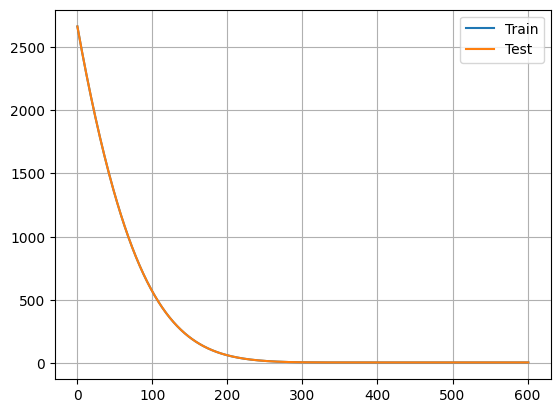

In [318]:
plot_losses(train_losses_dtrf, test_losses_dtrf)

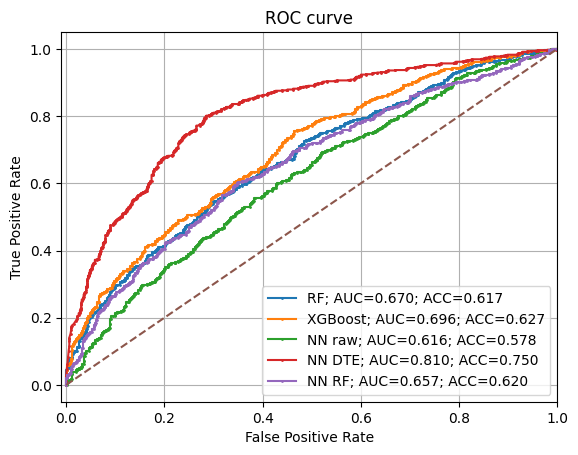

In [319]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, y_hat_dtrf], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'NN RF']
)

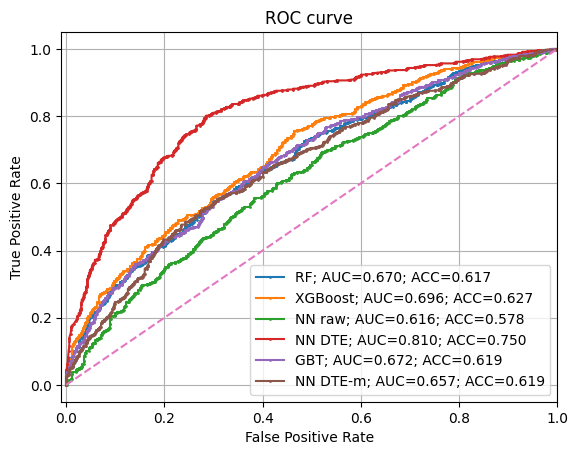

In [301]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, decision_trees_m[0].predict_proba(Xs['test'])[:,1], y_hat_dtm], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'GBT', 'NN DTE-m']
)

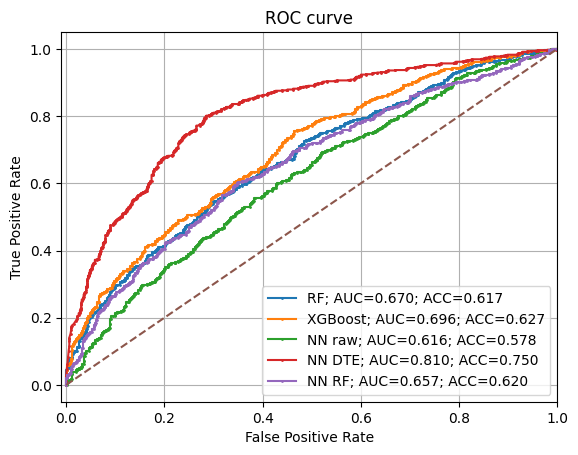

In [320]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, y_hat_dtrf], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'NN RF']
)

#### XGBoost

In [198]:
le_xg = OrdinalEncoder()
le_xg.fit(bst.apply(Xs['train']))

OrdinalEncoder()

In [199]:
Xs_dtxg = {key: th.tensor(le_xg.transform(bst.apply(Xs[key]))).long() for key in Xs.keys()}

In [200]:
n_uniques_xg = (Xs_dtxg['train'].max(dim=0)[0]+1).numpy()
n_uniques_xg

array([133, 121, 128, 133, 129, 123, 118, 157, 134, 138, 142, 144, 147,
       145, 145, 144, 136, 144, 128, 127, 130, 125, 129, 117, 126, 104,
       106, 154, 142,  96, 141, 107, 150, 126, 134, 166, 135, 136, 147,
       106, 131, 137, 158, 131, 135, 133, 136, 120, 130, 135, 118, 131,
       126, 130, 132, 157, 112, 134, 133, 128, 135, 120, 134, 136, 136,
       113, 130, 124, 134, 159, 114, 142, 139, 120, 112, 123, 151, 116,
       122, 112, 109, 141, 144, 124, 124,  85, 163, 124, 133, 102, 131,
        85, 121, 143,  81, 116, 134, 123, 139,  47, 152, 139,  95, 129,
       134, 132,  80,  46, 120,  97,  47, 115,  96,  49, 107,  95,  48,
        72, 129, 119, 113,  90, 114,  92, 100, 128, 130, 144, 102, 129,
        45, 116, 106,  72, 141, 117, 129, 125,  45, 108, 117,  62,  74,
       120, 156, 109, 132,  63,  45, 136, 129,  54, 105, 101,  86, 117,
        42,  85, 134, 110, 124, 130,  96, 106, 121,  42, 106, 142,  62,
       136,  73, 128, 108,  98, 110,  85,  65,  97,  76,  84, 13

In [201]:
def objective_xgb_nn(trial):
    embed_dim = 1
    
    hidden_dim = trial.suggest_int('hidden_dim', 8, 2048, log=True)
    dropout = trial.suggest_float('dropout', 0, 0.99)

    model_dt_xg = nn.Sequential(
        NumericEmbedding(n_uniques_xg, embed_dim, 'concat'),
        nn.Dropout(dropout),
        FeedForwardMLPResidual(
            d_model=n_uniques_xg.shape[0]*embed_dim, 
            dim_feedforward=hidden_dim, dropout=dropout,
        ),
        nn.Linear(n_uniques_xg.shape[0]*embed_dim, 1),
    )
    
    train_losses_dtxg, test_losses_dtxg, y_hat_dtxg = train(
        model_dt_xg, Xs_dtxg['train'], ys['train'], Xs_dtxg['valid'], ys['valid'], Xs_dtxg['test'], 
        N_epochs, 
        stop_criteria=stop_criteria, 
        l1_lambda=1e-3,
    )
    return test_losses_dtxg[-1]

In [202]:
study_xgb_nn = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="eye-movement-xgb-nn"
)
study_xgb_nn.optimize(objective_xgb_nn, n_trials=30)

[I 2023-01-23 11:42:56,900] A new study created in RDB with name: eye-movement-xgb-nn
[I 2023-01-23 11:43:13,697] Trial 0 finished with value: 3.7383837699890137 and parameters: {'hidden_dim': 21, 'dropout': 0.7222015832789622}. Best is trial 0 with value: 3.7383837699890137.


Early stopping at epoch 138 with valid acc 0.601


[I 2023-01-23 11:43:36,940] Trial 1 finished with value: 2.3793578147888184 and parameters: {'hidden_dim': 71, 'dropout': 0.46886608227904786}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 189 with valid acc 0.620


[I 2023-01-23 11:43:53,995] Trial 2 finished with value: 4.075418472290039 and parameters: {'hidden_dim': 94, 'dropout': 0.4137790978163996}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 137 with valid acc 0.629


[I 2023-01-23 11:44:26,575] Trial 3 finished with value: 3.3701579570770264 and parameters: {'hidden_dim': 1444, 'dropout': 0.33637074047825277}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 177 with valid acc 0.607


[I 2023-01-23 11:45:33,290] Trial 4 finished with value: 2.479295015335083 and parameters: {'hidden_dim': 1579, 'dropout': 0.6041745645859852}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 353 with valid acc 0.618


[I 2023-01-23 11:46:21,998] Trial 5 finished with value: 2.8036251068115234 and parameters: {'hidden_dim': 22, 'dropout': 0.4185777168825747}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 403 with valid acc 0.636


[I 2023-01-23 11:46:43,320] Trial 6 finished with value: 2.3831610679626465 and parameters: {'hidden_dim': 79, 'dropout': 0.6365238752853798}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 172 with valid acc 0.635


[I 2023-01-23 11:47:28,342] Trial 7 finished with value: 3.5775110721588135 and parameters: {'hidden_dim': 14, 'dropout': 0.022930581951008003}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 374 with valid acc 0.620


[I 2023-01-23 11:47:51,143] Trial 8 finished with value: 3.0702548027038574 and parameters: {'hidden_dim': 344, 'dropout': 0.43985054896753295}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 164 with valid acc 0.617


[I 2023-01-23 11:48:12,393] Trial 9 finished with value: 4.048081398010254 and parameters: {'hidden_dim': 182, 'dropout': 0.057292275763417104}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 165 with valid acc 0.594


[I 2023-01-23 11:48:28,823] Trial 10 finished with value: 3.759124279022217 and parameters: {'hidden_dim': 8, 'dropout': 0.9517580278118749}. Best is trial 1 with value: 2.3793578147888184.


Early stopping at epoch 135 with valid acc 0.588


[I 2023-01-23 11:49:21,541] Trial 11 finished with value: 2.143956184387207 and parameters: {'hidden_dim': 56, 'dropout': 0.64071993632453}. Best is trial 11 with value: 2.143956184387207.


Early stopping at epoch 429 with valid acc 0.652


[I 2023-01-23 11:49:55,932] Trial 12 finished with value: 1.6024059057235718 and parameters: {'hidden_dim': 44, 'dropout': 0.8353088290576889}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 279 with valid acc 0.651


[I 2023-01-23 11:50:36,952] Trial 13 finished with value: 1.7645039558410645 and parameters: {'hidden_dim': 38, 'dropout': 0.8310762874509063}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 334 with valid acc 0.654


[I 2023-01-23 11:50:51,331] Trial 14 finished with value: 5.193536758422852 and parameters: {'hidden_dim': 36, 'dropout': 0.9812113695033587}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 116 with valid acc 0.563


[I 2023-01-23 11:51:41,014] Trial 15 finished with value: 1.9402803182601929 and parameters: {'hidden_dim': 35, 'dropout': 0.8294954056362683}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 405 with valid acc 0.640


[I 2023-01-23 11:52:48,478] Trial 16 finished with value: 2.2327911853790283 and parameters: {'hidden_dim': 200, 'dropout': 0.8328573788831105}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 519 with valid acc 0.648


[I 2023-01-23 11:53:05,794] Trial 17 finished with value: 3.474782705307007 and parameters: {'hidden_dim': 8, 'dropout': 0.8338720320170989}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 142 with valid acc 0.617


[I 2023-01-23 11:53:21,167] Trial 18 finished with value: 4.542380332946777 and parameters: {'hidden_dim': 36, 'dropout': 0.9043249706491895}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 124 with valid acc 0.605


[I 2023-01-23 11:53:41,987] Trial 19 finished with value: 2.4796128273010254 and parameters: {'hidden_dim': 125, 'dropout': 0.7743571260679757}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 165 with valid acc 0.607


[I 2023-01-23 11:53:56,564] Trial 20 finished with value: 5.073904514312744 and parameters: {'hidden_dim': 57, 'dropout': 0.9821325876330836}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 118 with valid acc 0.532


[I 2023-01-23 11:54:33,000] Trial 21 finished with value: 1.9288198947906494 and parameters: {'hidden_dim': 33, 'dropout': 0.8257378908163072}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 297 with valid acc 0.630


[I 2023-01-23 11:55:20,175] Trial 22 finished with value: 1.8132317066192627 and parameters: {'hidden_dim': 19, 'dropout': 0.8793803902628993}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 387 with valid acc 0.651


[I 2023-01-23 11:56:19,447] Trial 23 finished with value: 1.7186557054519653 and parameters: {'hidden_dim': 13, 'dropout': 0.8850982230834245}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 487 with valid acc 0.655


[I 2023-01-23 11:57:04,657] Trial 24 finished with value: 2.1584510803222656 and parameters: {'hidden_dim': 13, 'dropout': 0.7209751311784395}. Best is trial 12 with value: 1.6024059057235718.


Early stopping at epoch 369 with valid acc 0.642


[I 2023-01-23 11:57:44,974] Trial 25 finished with value: 1.5530349016189575 and parameters: {'hidden_dim': 14, 'dropout': 0.9107133668470376}. Best is trial 25 with value: 1.5530349016189575.


Early stopping at epoch 330 with valid acc 0.635


[I 2023-01-23 11:58:24,832] Trial 26 finished with value: 1.485979676246643 and parameters: {'hidden_dim': 15, 'dropout': 0.9079520121645478}. Best is trial 26 with value: 1.485979676246643.


Early stopping at epoch 326 with valid acc 0.645


[I 2023-01-23 11:59:09,960] Trial 27 finished with value: 1.4426794052124023 and parameters: {'hidden_dim': 8, 'dropout': 0.9241883964887763}. Best is trial 27 with value: 1.4426794052124023.


Early stopping at epoch 371 with valid acc 0.668


[I 2023-01-23 11:59:27,109] Trial 28 finished with value: 3.4973621368408203 and parameters: {'hidden_dim': 9, 'dropout': 0.9896541343235978}. Best is trial 27 with value: 1.4426794052124023.


Early stopping at epoch 140 with valid acc 0.528


[I 2023-01-23 12:00:13,970] Trial 29 finished with value: 1.7346150875091553 and parameters: {'hidden_dim': 22, 'dropout': 0.7359849356307585}. Best is trial 27 with value: 1.4426794052124023.


Early stopping at epoch 386 with valid acc 0.640


In [203]:
best_params_xgb_nn = study_xgb_nn.best_params
best_params_xgb_nn

{'dropout': 0.9241883964887763, 'hidden_dim': 8}

In [204]:
embed_dim = 1
hidden_dim = best_params_xgb_nn['hidden_dim']
dropout = best_params_xgb_nn['dropout']

model_dt_xg = nn.Sequential(
    NumericEmbedding(n_uniques_xg, embed_dim, 'concat'),
    nn.Dropout(dropout),
    FeedForwardMLPResidual(
        d_model=n_uniques_xg.shape[0]*embed_dim, 
        dim_feedforward=hidden_dim, dropout=dropout,
    ),
    nn.Linear(n_uniques_xg.shape[0]*embed_dim, 1),
)

train_losses_dtxg, test_losses_dtxg, y_hat_dtxg = train(
    model_dt_xg, Xs_dtxg['train'], ys['train'], Xs_dtxg['valid'], ys['valid'], Xs_dtxg['test'], 
    N_epochs, 
    stop_criteria=stop_criteria, 
    l1_lambda=1e-3,
)

Early stopping at epoch 497 with valid acc 0.651


In [205]:
sum([p.numel() for p in model_dt_xg.parameters()])

43403

In [206]:
# model_dt_rf

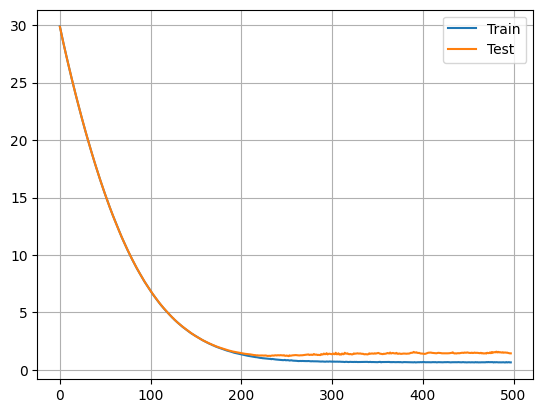

In [207]:
plot_losses(train_losses_dtxg, test_losses_dtxg)

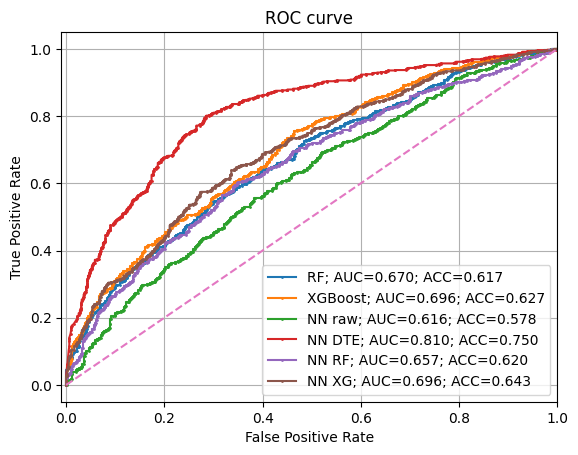

In [321]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, y_hat_dtrf, y_hat_dtxg], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'NN RF', 'NN XG']
)

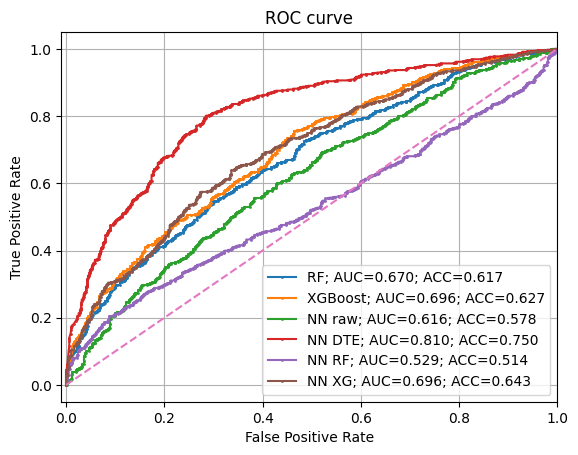

In [307]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, y_hat_dtrf, y_hat_dtxg], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'NN RF', 'NN XG']
)